In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import polars as pl

from sklearn.tree import DecisionTreeClassifier, plot_tree,  _tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
import lightgbm as lgb
from sklearn.impute import SimpleImputer
import gc
from joblib import Parallel, delayed
from pathlib import Path
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour

from time import time
import os
import pickle

In [2]:
SEMILLAS = [550007, 550019, 550031, 550033, 550047]

mes_train = 202103, 202102, 202101
mes_test = 202104
mes_kaggle = 202106
ganancia_acierto = 780000
costo_estimulo = 20000
# =====================

In [3]:
#Que archivos son? esos meses seleccionados SIN SLOPE
#df_train.write_csv("data/df_train_01_02_03.csv")
#df_test.write_csv("data/df_test_04.csv")   

In [3]:
#df_train = pd.read_csv("data/df_train_fe.csv")
df_test = pd.read_csv("data/df_test_04.csv")

In [4]:
df_train = pd.read_csv("data/df_train_c12.csv")

In [5]:
df_train_03_continua = pd.read_csv("data/df_train_03_continua.csv")

In [ ]:
# df_train = pd.concat([df_train, df_train_03_continua], ignore_index=True)
# df_train = df_train.copy()  # <-- recompacta el DataFrame

#optimizar modelo final

# df_train = pd.concat([df_train, df_test], ignore_index=True)
# df_train = df_train.copy()  # <-- recompacta el DataFrame


In [24]:
df_train.shape

(5284, 803)

In [25]:
df_test.shape

(163418, 803)

In [ ]:
# df_train_03_continua = pd.read_csv("data/df_train_01_02_03.csv")
# #Selecciono solo las 202103 en foto_es y continua en clase_ternaria
# df_train_03_continua = df_train_03_continua[(df_train_03_continua['foto_mes'] == 202103) & (df_train_03_continua['clase_ternaria'] == 'CONTINUA')]   

In [ ]:
#guardar en csv
#df_train_03_continua.to_csv("data/df_train_03_continua.csv", index=False)

In [ ]:
# Filtrar los meses deseados
# df_train = df_trainc


# #Guardar en CSV
# df_train.to_csv("df_train_c12.csv", index=False)


In [10]:
# Liberar memoria antes de empezar
gc.collect()

1515

In [5]:
df_kaggle = pd.read_csv("data/df_kaggle.csv")

In [4]:
#tiene mi df_train la columna "clase_ternaria"?
print("clase_ternaria" in df_train.columns)

True


##Optimización con LightGBM

In [6]:
df_train['clase_peso'] = 1.0

df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

In [7]:

import lightgbm as lgb
from sklearn.model_selection import train_test_split

# Separar X e y
X = df_train.drop(["clase_ternaria", "clase_peso"], axis=1)  # ✅ Sacamos también clase_peso
y = df_train["clase_ternaria"]
pesos = df_train["clase_peso"]  # ✅ Guardamos los pesos

# Binarizar y
y_binaria = (y != "CONTINUA").astype(int)

# Split 70/30 (ahora incluimos los pesos)
X_train, X_val, y_train, y_val, pesos_train, pesos_val = train_test_split(
    X, y_binaria, pesos,  # ✅ Separamos X, y Y pesos
    train_size=0.7,
    random_state=42,
    stratify=y_binaria
)

print("Train:", X_train.shape, y_train.shape, pesos_train.shape)
print("Validation:", X_val.shape, y_val.shape, pesos_val.shape)

# Ahora en el Dataset:
train_data = lgb.Dataset(X_train,
                          label=y_train,
                          weight=pesos_train  # ✅ Usamos los pesos del train
                          )

Train: (118091, 802) (118091,) (118091,)
Validation: (50611, 802) (50611,) (50611,)


In [8]:
def ganancia_prob(y_pred, data):
  weight = data.get_weight()
  ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - np.where(weight < 1.00002, costo_estimulo, 0)
  ganancia = ganancia[np.argsort(y_pred)[::-1]]
  ganancia = np.cumsum(ganancia)  # ✅ Bien
  return 'gan_eval', np.max(ganancia), True
  


In [12]:
def objective(trial):

    num_leaves = trial.suggest_int('num_leaves', 8, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.005, 0.1) # mas bajo, más iteraciones necesita
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 50, 1500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.1, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.1, 1.0),

    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_data_in_leaf': min_data_in_leaf,
        'feature_fraction': feature_fraction,
        'bagging_fraction': bagging_fraction,
        'seed': SEMILLAS[0],
        'verbose': -1
    }
    train_data = lgb.Dataset(X_train,
                              label=y_train, # eligir la clase
                              weight=pesos_train
                              )
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=1000, # modificar, subit y subir... y descomentar la línea inferior
        #early_stopping_rounds= int(50 + 5 / learning_rate),
        feval=ganancia_prob,
        stratified=True,
        nfold=4,
        seed=SEMILLAS[0],
        callbacks=[
                lgb.early_stopping(stopping_rounds=int(50 + 5/learning_rate), verbose=False),
                lgb.log_evaluation(period=200),
                ]
    )
    max_gan = max(cv_results['valid gan_eval-mean'])
    best_iter = cv_results['valid gan_eval-mean'].index(max_gan) + 1

    # Guardamos cual es la mejor iteración del modelo
    trial.set_user_attr("best_iter", best_iter)

    return max_gan * 4
# Al final de objective()
gc.collect()

#guardar el archivo en mi carpeta data
storage_name = "sqlite:///data/optimization_lgbm.db"

study_name = "exp_301_lgbm"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    storage=storage_name,
    load_if_exists=True,
)

[I 2025-10-11 18:15:39,218] Using an existing study with name 'exp_301_lgbm' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=1000) # subir subir

[200]	valid's gan_eval: 4.4129e+08 + 9.896e+06
[400]	valid's gan_eval: 4.4245e+08 + 8.96452e+06


[I 2025-10-11 18:18:45,829] Trial 618 finished with value: 1772580000.0 and parameters: {'num_leaves': 121, 'learning_rate': 0.09205214361431267, 'min_data_in_leaf': 250, 'feature_fraction': 0.9681620891865248, 'bagging_fraction': 0.6854377120650615}. Best is trial 618 with value: 1772580000.0.
[I 2025-10-11 18:20:37,456] Trial 619 finished with value: 1768300000.0 and parameters: {'num_leaves': 136, 'learning_rate': 0.09266697434823615, 'min_data_in_leaf': 190, 'feature_fraction': 0.9620297469939149, 'bagging_fraction': 0.6808000809271826}. Best is trial 618 with value: 1772580000.0.


[200]	valid's gan_eval: 4.42285e+08 + 9.22111e+06


[I 2025-10-11 18:22:30,252] Trial 620 finished with value: 1772600000.0 and parameters: {'num_leaves': 110, 'learning_rate': 0.0929856534722915, 'min_data_in_leaf': 158, 'feature_fraction': 0.7180978090458432, 'bagging_fraction': 0.688519495004244}. Best is trial 620 with value: 1772600000.0.


[200]	valid's gan_eval: 4.4248e+08 + 8.81327e+06


[I 2025-10-11 18:25:17,591] Trial 621 finished with value: 1775040000.0 and parameters: {'num_leaves': 117, 'learning_rate': 0.09222910204863323, 'min_data_in_leaf': 140, 'feature_fraction': 0.5678689962930354, 'bagging_fraction': 0.6828555721849241}. Best is trial 621 with value: 1775040000.0.


[200]	valid's gan_eval: 4.4043e+08 + 9.06838e+06


[I 2025-10-11 18:26:58,603] Trial 622 finished with value: 1767700000.0 and parameters: {'num_leaves': 109, 'learning_rate': 0.09210470216290986, 'min_data_in_leaf': 152, 'feature_fraction': 0.7802708424194575, 'bagging_fraction': 0.6817972264596642}. Best is trial 621 with value: 1775040000.0.


[200]	valid's gan_eval: 4.4258e+08 + 7.94183e+06


[I 2025-10-11 18:29:54,044] Trial 623 finished with value: 1774280000.0 and parameters: {'num_leaves': 121, 'learning_rate': 0.09155708642904306, 'min_data_in_leaf': 129, 'feature_fraction': 0.7141670124110642, 'bagging_fraction': 0.6865908838237087}. Best is trial 621 with value: 1775040000.0.


[200]	valid's gan_eval: 4.4189e+08 + 7.96445e+06
[400]	valid's gan_eval: 4.43565e+08 + 9.29704e+06
[600]	valid's gan_eval: 4.4425e+08 + 8.56554e+06


[I 2025-10-11 18:34:20,848] Trial 624 finished with value: 1778520000.0 and parameters: {'num_leaves': 120, 'learning_rate': 0.0920096359388223, 'min_data_in_leaf': 146, 'feature_fraction': 0.7096653678781808, 'bagging_fraction': 0.6829550764292338}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.42865e+08 + 9.37527e+06


[I 2025-10-11 18:36:54,891] Trial 625 finished with value: 1776340000.0 and parameters: {'num_leaves': 117, 'learning_rate': 0.09159211191262864, 'min_data_in_leaf': 121, 'feature_fraction': 0.4927834242580219, 'bagging_fraction': 0.6820683083689182}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.40105e+08 + 7.68774e+06
[400]	valid's gan_eval: 4.41325e+08 + 6.78611e+06
[600]	valid's gan_eval: 4.4332e+08 + 6.98881e+06


[I 2025-10-11 18:41:13,866] Trial 626 finished with value: 1775300000.0 and parameters: {'num_leaves': 113, 'learning_rate': 0.09009322030913135, 'min_data_in_leaf': 117, 'feature_fraction': 0.7044278996548154, 'bagging_fraction': 0.6540710899986274}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.42725e+08 + 7.44143e+06
[400]	valid's gan_eval: 4.43215e+08 + 8.79962e+06


[I 2025-10-11 18:45:00,200] Trial 627 finished with value: 1776880000.0 and parameters: {'num_leaves': 114, 'learning_rate': 0.0893431135233372, 'min_data_in_leaf': 131, 'feature_fraction': 0.6919762428384105, 'bagging_fraction': 0.6461566714951867}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41195e+08 + 6.67903e+06


[I 2025-10-11 18:46:36,818] Trial 628 finished with value: 1767680000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08729570008012077, 'min_data_in_leaf': 130, 'feature_fraction': 0.7066620631632573, 'bagging_fraction': 0.6521503355634228}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.409e+08 + 1.02036e+07


[I 2025-10-11 18:48:06,942] Trial 629 finished with value: 1769780000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08616467472944297, 'min_data_in_leaf': 134, 'feature_fraction': 0.7141164352594916, 'bagging_fraction': 0.6351396972034872}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4229e+08 + 6.99915e+06


[I 2025-10-11 18:50:15,785] Trial 630 finished with value: 1769520000.0 and parameters: {'num_leaves': 112, 'learning_rate': 0.08580182348182014, 'min_data_in_leaf': 136, 'feature_fraction': 0.7167840749656189, 'bagging_fraction': 0.6452778794504531}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.40265e+08 + 9.17135e+06
[400]	valid's gan_eval: 4.40585e+08 + 8.71786e+06
[600]	valid's gan_eval: 4.42455e+08 + 8.2354e+06


[I 2025-10-11 18:54:47,938] Trial 631 finished with value: 1770920000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08595106365002404, 'min_data_in_leaf': 131, 'feature_fraction': 0.7022962364546865, 'bagging_fraction': 0.6299516987929439}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4183e+08 + 5.96598e+06
[400]	valid's gan_eval: 4.4309e+08 + 6.31998e+06


[I 2025-10-11 18:58:05,379] Trial 632 finished with value: 1773880000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08568910637377465, 'min_data_in_leaf': 134, 'feature_fraction': 0.720312082255957, 'bagging_fraction': 0.6330737547268392}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41005e+08 + 1.00229e+07
[400]	valid's gan_eval: 4.4242e+08 + 8.58402e+06
[600]	valid's gan_eval: 4.4348e+08 + 8.20304e+06


[I 2025-10-11 19:02:07,357] Trial 633 finished with value: 1775920000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08597306985440542, 'min_data_in_leaf': 139, 'feature_fraction': 0.7019119606658201, 'bagging_fraction': 0.6325022533246519}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41935e+08 + 9.36232e+06
[400]	valid's gan_eval: 4.42635e+08 + 9.84718e+06


[I 2025-10-11 19:05:09,611] Trial 634 finished with value: 1777260000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08100278348947469, 'min_data_in_leaf': 142, 'feature_fraction': 0.717189103927269, 'bagging_fraction': 0.6056075121415782}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4218e+08 + 7.60504e+06
[400]	valid's gan_eval: 4.42585e+08 + 7.23701e+06


[I 2025-10-11 19:08:45,317] Trial 635 finished with value: 1773680000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08225600557652417, 'min_data_in_leaf': 130, 'feature_fraction': 0.715130834755023, 'bagging_fraction': 0.6070560309866684}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.3994e+08 + 7.14917e+06


[I 2025-10-11 19:11:43,871] Trial 636 finished with value: 1765900000.0 and parameters: {'num_leaves': 119, 'learning_rate': 0.08193132519957427, 'min_data_in_leaf': 137, 'feature_fraction': 0.7180220255219022, 'bagging_fraction': 0.5955621284399559}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.40725e+08 + 8.02261e+06
[400]	valid's gan_eval: 4.42675e+08 + 8.15134e+06


[I 2025-10-11 19:15:24,663] Trial 637 finished with value: 1774560000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08133562231889907, 'min_data_in_leaf': 143, 'feature_fraction': 0.7061749836683562, 'bagging_fraction': 0.5744150410454308}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4137e+08 + 7.31516e+06


[I 2025-10-11 19:16:59,427] Trial 638 finished with value: 1768720000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08252459480160708, 'min_data_in_leaf': 122, 'feature_fraction': 0.7171040829359588, 'bagging_fraction': 0.5998902151715183}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.42435e+08 + 9.33869e+06
[400]	valid's gan_eval: 4.43335e+08 + 8.13851e+06


[I 2025-10-11 19:20:26,367] Trial 639 finished with value: 1776760000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08125336981624465, 'min_data_in_leaf': 138, 'feature_fraction': 0.7151496087384445, 'bagging_fraction': 0.5812711492116222}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.43085e+08 + 8.72075e+06


[I 2025-10-11 19:22:19,809] Trial 640 finished with value: 1776960000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08309504344883008, 'min_data_in_leaf': 135, 'feature_fraction': 0.7168035413874273, 'bagging_fraction': 0.5773228885802223}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41065e+08 + 9.00013e+06


[I 2025-10-11 19:25:09,489] Trial 641 finished with value: 1768920000.0 and parameters: {'num_leaves': 118, 'learning_rate': 0.08109360925672575, 'min_data_in_leaf': 127, 'feature_fraction': 0.71606469566492, 'bagging_fraction': 0.5613416583121413}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41475e+08 + 9.52559e+06


[I 2025-10-11 19:28:07,342] Trial 642 finished with value: 1768620000.0 and parameters: {'num_leaves': 117, 'learning_rate': 0.08077182254186135, 'min_data_in_leaf': 136, 'feature_fraction': 0.7162660387904679, 'bagging_fraction': 0.5606631212081168}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.40665e+08 + 7.66816e+06


[I 2025-10-11 19:29:58,554] Trial 643 finished with value: 1764460000.0 and parameters: {'num_leaves': 115, 'learning_rate': 0.08229630215642206, 'min_data_in_leaf': 128, 'feature_fraction': 0.7184965866144452, 'bagging_fraction': 0.5639402493762989}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4118e+08 + 7.60086e+06


[I 2025-10-11 19:32:51,912] Trial 644 finished with value: 1772160000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08083034530272337, 'min_data_in_leaf': 157, 'feature_fraction': 0.6841845814983083, 'bagging_fraction': 0.5723763672100856}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.39685e+08 + 8.43124e+06


[I 2025-10-11 19:34:52,774] Trial 645 finished with value: 1764440000.0 and parameters: {'num_leaves': 116, 'learning_rate': 0.08019632991991259, 'min_data_in_leaf': 54, 'feature_fraction': 0.687222967682866, 'bagging_fraction': 0.5197653943689311}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4055e+08 + 1.02276e+07
[400]	valid's gan_eval: 4.42845e+08 + 8.17256e+06
[600]	valid's gan_eval: 4.4313e+08 + 8.89331e+06


[I 2025-10-11 19:39:20,244] Trial 646 finished with value: 1776220000.0 and parameters: {'num_leaves': 127, 'learning_rate': 0.0782911312617625, 'min_data_in_leaf': 165, 'feature_fraction': 0.7049032241648959, 'bagging_fraction': 0.5744014766828677}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4079e+08 + 7.41024e+06
[400]	valid's gan_eval: 4.41965e+08 + 7.39093e+06
[600]	valid's gan_eval: 4.4339e+08 + 6.94714e+06
[800]	valid's gan_eval: 4.43735e+08 + 6.62221e+06
[1000]	valid's gan_eval: 4.4412e+08 + 6.29833e+06


[I 2025-10-11 19:45:10,159] Trial 647 finished with value: 1776980000.0 and parameters: {'num_leaves': 125, 'learning_rate': 0.07702552329054131, 'min_data_in_leaf': 162, 'feature_fraction': 0.7381483133756722, 'bagging_fraction': 0.575261759712274}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.411e+08 + 7.78353e+06
[400]	valid's gan_eval: 4.41715e+08 + 6.92811e+06
[600]	valid's gan_eval: 4.42575e+08 + 8.78739e+06


[I 2025-10-11 19:49:55,882] Trial 648 finished with value: 1771980000.0 and parameters: {'num_leaves': 129, 'learning_rate': 0.07841937413284829, 'min_data_in_leaf': 167, 'feature_fraction': 0.7352730433709035, 'bagging_fraction': 0.5691324542602513}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41445e+08 + 9.00941e+06
[400]	valid's gan_eval: 4.4222e+08 + 8.02709e+06


[I 2025-10-11 19:53:55,833] Trial 649 finished with value: 1773840000.0 and parameters: {'num_leaves': 129, 'learning_rate': 0.07830091425767871, 'min_data_in_leaf': 90, 'feature_fraction': 0.7373686342294309, 'bagging_fraction': 0.5720114866577185}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4035e+08 + 6.91135e+06


[I 2025-10-11 19:56:38,660] Trial 650 finished with value: 1765840000.0 and parameters: {'num_leaves': 128, 'learning_rate': 0.07649927004056631, 'min_data_in_leaf': 80, 'feature_fraction': 0.7374611579502226, 'bagging_fraction': 0.5825922800132294}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4117e+08 + 7.64427e+06
[400]	valid's gan_eval: 4.4198e+08 + 6.72773e+06
[600]	valid's gan_eval: 4.443e+08 + 6.14635e+06


[I 2025-10-11 20:01:25,363] Trial 651 finished with value: 1777880000.0 and parameters: {'num_leaves': 128, 'learning_rate': 0.0786977041516812, 'min_data_in_leaf': 167, 'feature_fraction': 0.6848250230633333, 'bagging_fraction': 0.5376848383117074}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.409e+08 + 9.02166e+06
[400]	valid's gan_eval: 4.427e+08 + 9.4334e+06


[I 2025-10-11 20:05:16,436] Trial 652 finished with value: 1773220000.0 and parameters: {'num_leaves': 127, 'learning_rate': 0.07804619418172117, 'min_data_in_leaf': 165, 'feature_fraction': 0.6732135931538347, 'bagging_fraction': 0.5344854766802944}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.42325e+08 + 8.35189e+06
[400]	valid's gan_eval: 4.42505e+08 + 6.73208e+06
[600]	valid's gan_eval: 4.4283e+08 + 7.08613e+06


[I 2025-10-11 20:09:41,707] Trial 653 finished with value: 1774360000.0 and parameters: {'num_leaves': 127, 'learning_rate': 0.07852268605370233, 'min_data_in_leaf': 157, 'feature_fraction': 0.6781764331785606, 'bagging_fraction': 0.5491021763213589}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41875e+08 + 9.31155e+06
[400]	valid's gan_eval: 4.43215e+08 + 8.35014e+06


[I 2025-10-11 20:13:57,494] Trial 654 finished with value: 1776500000.0 and parameters: {'num_leaves': 130, 'learning_rate': 0.07761260987829023, 'min_data_in_leaf': 168, 'feature_fraction': 0.6807392103441195, 'bagging_fraction': 0.5344220636035394}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.403e+08 + 6.82388e+06


[I 2025-10-11 20:15:49,483] Trial 655 finished with value: 1768340000.0 and parameters: {'num_leaves': 127, 'learning_rate': 0.07796372896630661, 'min_data_in_leaf': 168, 'feature_fraction': 0.676077560223749, 'bagging_fraction': 0.5284204189090917}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41465e+08 + 8.35068e+06
[400]	valid's gan_eval: 4.4185e+08 + 6.74695e+06


[I 2025-10-11 20:19:11,345] Trial 656 finished with value: 1772920000.0 and parameters: {'num_leaves': 127, 'learning_rate': 0.07705762611094796, 'min_data_in_leaf': 96, 'feature_fraction': 0.6891316115728002, 'bagging_fraction': 0.5543658816712513}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.40765e+08 + 6.19655e+06
[400]	valid's gan_eval: 4.41945e+08 + 7.40179e+06
[600]	valid's gan_eval: 4.429e+08 + 7.65615e+06


[I 2025-10-11 20:23:33,986] Trial 657 finished with value: 1774260000.0 and parameters: {'num_leaves': 127, 'learning_rate': 0.07885898474116666, 'min_data_in_leaf': 91, 'feature_fraction': 0.685578526383242, 'bagging_fraction': 0.5346753049974537}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.4106e+08 + 6.8742e+06


[I 2025-10-11 20:26:41,690] Trial 658 finished with value: 1773020000.0 and parameters: {'num_leaves': 139, 'learning_rate': 0.07412743884469271, 'min_data_in_leaf': 87, 'feature_fraction': 0.6860761578560488, 'bagging_fraction': 0.5379443280971999}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.40935e+08 + 1.04524e+07


[I 2025-10-11 20:28:54,801] Trial 659 finished with value: 1768780000.0 and parameters: {'num_leaves': 142, 'learning_rate': 0.07438000998618109, 'min_data_in_leaf': 90, 'feature_fraction': 0.6641494990516561, 'bagging_fraction': 0.5426288584369956}. Best is trial 624 with value: 1778520000.0.


[200]	valid's gan_eval: 4.41325e+08 + 8.99644e+06
[400]	valid's gan_eval: 4.42925e+08 + 1.00572e+07
[600]	valid's gan_eval: 4.44545e+08 + 7.61784e+06


[I 2025-10-11 20:33:26,538] Trial 660 finished with value: 1779420000.0 and parameters: {'num_leaves': 106, 'learning_rate': 0.07618431759790821, 'min_data_in_leaf': 56, 'feature_fraction': 0.6916923626912693, 'bagging_fraction': 0.5017881175623019}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.4002e+08 + 8.48044e+06
[400]	valid's gan_eval: 4.40615e+08 + 7.33574e+06


[I 2025-10-11 20:37:07,727] Trial 661 finished with value: 1767320000.0 and parameters: {'num_leaves': 136, 'learning_rate': 0.07716513271974224, 'min_data_in_leaf': 53, 'feature_fraction': 0.7579912191575744, 'bagging_fraction': 0.5079134023577749}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.3968e+08 + 9.97492e+06


[I 2025-10-11 20:39:45,838] Trial 662 finished with value: 1769860000.0 and parameters: {'num_leaves': 106, 'learning_rate': 0.07496940752712183, 'min_data_in_leaf': 87, 'feature_fraction': 0.6914426968626916, 'bagging_fraction': 0.5340012440646495}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.4033e+08 + 8.0537e+06


[I 2025-10-11 20:42:31,982] Trial 663 finished with value: 1765580000.0 and parameters: {'num_leaves': 125, 'learning_rate': 0.07887832953004306, 'min_data_in_leaf': 97, 'feature_fraction': 0.652188787218309, 'bagging_fraction': 0.5394874417331296}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.40855e+08 + 7.72182e+06
[400]	valid's gan_eval: 4.4285e+08 + 8.16253e+06


[I 2025-10-11 20:46:13,216] Trial 664 finished with value: 1775320000.0 and parameters: {'num_leaves': 135, 'learning_rate': 0.07648312898169136, 'min_data_in_leaf': 180, 'feature_fraction': 0.6915288842171021, 'bagging_fraction': 0.5005228308265028}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.4244e+08 + 9.71462e+06


[I 2025-10-11 20:48:59,676] Trial 665 finished with value: 1773260000.0 and parameters: {'num_leaves': 134, 'learning_rate': 0.07654608497965462, 'min_data_in_leaf': 73, 'feature_fraction': 0.6764179705833953, 'bagging_fraction': 0.49313338025393727}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.3901e+08 + 8.23231e+06


[I 2025-10-11 20:51:05,874] Trial 666 finished with value: 1761760000.0 and parameters: {'num_leaves': 135, 'learning_rate': 0.07294246855111414, 'min_data_in_leaf': 62, 'feature_fraction': 0.6705172709708325, 'bagging_fraction': 0.502584139357427}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.4167e+08 + 8.82084e+06
[400]	valid's gan_eval: 4.4201e+08 + 7.25364e+06


[I 2025-10-11 20:54:50,373] Trial 667 finished with value: 1771880000.0 and parameters: {'num_leaves': 146, 'learning_rate': 0.07571284197759803, 'min_data_in_leaf': 179, 'feature_fraction': 0.7413486832838301, 'bagging_fraction': 0.4778269258209781}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.41215e+08 + 8.73098e+06


[I 2025-10-11 20:56:39,388] Trial 668 finished with value: 1769480000.0 and parameters: {'num_leaves': 104, 'learning_rate': 0.07901138930893656, 'min_data_in_leaf': 107, 'feature_fraction': 0.6311081753420322, 'bagging_fraction': 0.5166930281650347}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.40595e+08 + 8.98649e+06
[400]	valid's gan_eval: 4.4248e+08 + 7.67008e+06


[I 2025-10-11 21:00:12,698] Trial 669 finished with value: 1772240000.0 and parameters: {'num_leaves': 123, 'learning_rate': 0.07933038711380883, 'min_data_in_leaf': 74, 'feature_fraction': 0.6876360828181911, 'bagging_fraction': 0.5233482717288556}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.4085e+08 + 8.86623e+06
[400]	valid's gan_eval: 4.4275e+08 + 7.74145e+06


[I 2025-10-11 21:03:42,800] Trial 670 finished with value: 1775500000.0 and parameters: {'num_leaves': 133, 'learning_rate': 0.08353869160690229, 'min_data_in_leaf': 172, 'feature_fraction': 0.6993786543205622, 'bagging_fraction': 0.4845838458933781}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.4322e+08 + 7.23626e+06
[400]	valid's gan_eval: 4.43245e+08 + 6.91448e+06


[I 2025-10-11 21:07:27,574] Trial 671 finished with value: 1776180000.0 and parameters: {'num_leaves': 132, 'learning_rate': 0.08344380463286075, 'min_data_in_leaf': 180, 'feature_fraction': 0.7014926825414972, 'bagging_fraction': 0.4551874498000303}. Best is trial 660 with value: 1779420000.0.


[200]	valid's gan_eval: 4.41925e+08 + 7.6859e+06
[400]	valid's gan_eval: 4.43485e+08 + 7.14234e+06
[600]	valid's gan_eval: 4.45615e+08 + 6.03825e+06
[800]	valid's gan_eval: 4.4591e+08 + 6.26984e+06


[I 2025-10-11 21:13:08,077] Trial 672 finished with value: 1785980000.0 and parameters: {'num_leaves': 147, 'learning_rate': 0.07055166350630575, 'min_data_in_leaf': 183, 'feature_fraction': 0.6992396968297147, 'bagging_fraction': 0.49046102060858093}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4118e+08 + 9.75003e+06
[400]	valid's gan_eval: 4.424e+08 + 8.84257e+06


[I 2025-10-11 21:17:12,545] Trial 673 finished with value: 1770600000.0 and parameters: {'num_leaves': 165, 'learning_rate': 0.08391384248592725, 'min_data_in_leaf': 173, 'feature_fraction': 0.7002202775775977, 'bagging_fraction': 0.44403280598828854}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42785e+08 + 6.77796e+06


[I 2025-10-11 21:20:03,731] Trial 674 finished with value: 1774060000.0 and parameters: {'num_leaves': 151, 'learning_rate': 0.08342796201487192, 'min_data_in_leaf': 187, 'feature_fraction': 0.7573413944534099, 'bagging_fraction': 0.4658893778358344}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4182e+08 + 8.56333e+06


[I 2025-10-11 21:22:40,106] Trial 675 finished with value: 1768680000.0 and parameters: {'num_leaves': 151, 'learning_rate': 0.08024583972412486, 'min_data_in_leaf': 191, 'feature_fraction': 0.7572687058452864, 'bagging_fraction': 0.46231694784017874}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39795e+08 + 8.8448e+06


[I 2025-10-11 21:24:28,626] Trial 676 finished with value: 1762080000.0 and parameters: {'num_leaves': 131, 'learning_rate': 0.08384300557107836, 'min_data_in_leaf': 157, 'feature_fraction': 0.7332681346379305, 'bagging_fraction': 0.47329766788663785}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4092e+08 + 7.8532e+06
[400]	valid's gan_eval: 4.42175e+08 + 9.27032e+06
[600]	valid's gan_eval: 4.43595e+08 + 8.96805e+06
[800]	valid's gan_eval: 4.43985e+08 + 8.78857e+06


[I 2025-10-11 21:29:57,465] Trial 677 finished with value: 1778220000.0 and parameters: {'num_leaves': 161, 'learning_rate': 0.07040747031768689, 'min_data_in_leaf': 105, 'feature_fraction': 0.697788232758322, 'bagging_fraction': 0.4810222289725234}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3914e+08 + 9.38336e+06


[I 2025-10-11 21:32:30,078] Trial 678 finished with value: 1761720000.0 and parameters: {'num_leaves': 286, 'learning_rate': 0.08352543587661514, 'min_data_in_leaf': 184, 'feature_fraction': 0.7021086236693624, 'bagging_fraction': 0.4888688422913298}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4305e+08 + 7.46685e+06


[I 2025-10-11 21:35:09,745] Trial 679 finished with value: 1776000000.0 and parameters: {'num_leaves': 162, 'learning_rate': 0.08096075234083354, 'min_data_in_leaf': 114, 'feature_fraction': 0.6539179431035448, 'bagging_fraction': 0.46141955922897504}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4187e+08 + 8.66004e+06


[I 2025-10-11 21:38:28,583] Trial 680 finished with value: 1773720000.0 and parameters: {'num_leaves': 179, 'learning_rate': 0.08217870644334692, 'min_data_in_leaf': 157, 'feature_fraction': 0.6510739531667517, 'bagging_fraction': 0.45887772096563895}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39885e+08 + 9.41153e+06
[400]	valid's gan_eval: 4.41735e+08 + 8.35687e+06
[600]	valid's gan_eval: 4.4297e+08 + 8.67118e+06


[I 2025-10-11 21:43:23,136] Trial 681 finished with value: 1772740000.0 and parameters: {'num_leaves': 155, 'learning_rate': 0.07040995162961516, 'min_data_in_leaf': 103, 'feature_fraction': 0.6976365732225467, 'bagging_fraction': 0.483840118394782}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4141e+08 + 1.02169e+07


[I 2025-10-11 21:46:23,127] Trial 682 finished with value: 1772300000.0 and parameters: {'num_leaves': 166, 'learning_rate': 0.0719179702180788, 'min_data_in_leaf': 111, 'feature_fraction': 0.6602751160105678, 'bagging_fraction': 0.46524405577447936}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41315e+08 + 6.95318e+06
[400]	valid's gan_eval: 4.4445e+08 + 4.18219e+06


[I 2025-10-11 21:50:17,182] Trial 683 finished with value: 1778640000.0 and parameters: {'num_leaves': 166, 'learning_rate': 0.08080260772719637, 'min_data_in_leaf': 197, 'feature_fraction': 0.6967517662504901, 'bagging_fraction': 0.4017174867198463}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.412e+08 + 1.00488e+07


[I 2025-10-11 21:53:49,519] Trial 684 finished with value: 1769980000.0 and parameters: {'num_leaves': 169, 'learning_rate': 0.07984701459508808, 'min_data_in_leaf': 161, 'feature_fraction': 0.6982800372833183, 'bagging_fraction': 0.41271252579523243}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40975e+08 + 7.48349e+06
[400]	valid's gan_eval: 4.42375e+08 + 7.86616e+06
[600]	valid's gan_eval: 4.4312e+08 + 8.78483e+06


[I 2025-10-11 21:58:17,543] Trial 685 finished with value: 1774940000.0 and parameters: {'num_leaves': 177, 'learning_rate': 0.07634090501083293, 'min_data_in_leaf': 106, 'feature_fraction': 0.672169735607268, 'bagging_fraction': 0.396137031911555}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40785e+08 + 1.02845e+07


[I 2025-10-11 22:01:09,420] Trial 686 finished with value: 1766720000.0 and parameters: {'num_leaves': 195, 'learning_rate': 0.07701811221810352, 'min_data_in_leaf': 202, 'feature_fraction': 0.6666119673621319, 'bagging_fraction': 0.36635179231341297}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4068e+08 + 1.05361e+07


[I 2025-10-11 22:03:42,370] Trial 687 finished with value: 1769120000.0 and parameters: {'num_leaves': 105, 'learning_rate': 0.07506113860026982, 'min_data_in_leaf': 114, 'feature_fraction': 0.6057770771499289, 'bagging_fraction': 0.39125224590440105}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43905e+08 + 8.85022e+06


[I 2025-10-11 22:06:45,135] Trial 688 finished with value: 1778540000.0 and parameters: {'num_leaves': 161, 'learning_rate': 0.08067932297585592, 'min_data_in_leaf': 156, 'feature_fraction': 0.6361465617474715, 'bagging_fraction': 0.38679571595348666}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4283e+08 + 8.63852e+06
[400]	valid's gan_eval: 4.43305e+08 + 7.55581e+06
[600]	valid's gan_eval: 4.43635e+08 + 7.67654e+06


[I 2025-10-11 22:10:49,658] Trial 689 finished with value: 1776220000.0 and parameters: {'num_leaves': 174, 'learning_rate': 0.0806733277052149, 'min_data_in_leaf': 156, 'feature_fraction': 0.6430053712304727, 'bagging_fraction': 0.39151730405215524}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4153e+08 + 8.71927e+06
[400]	valid's gan_eval: 4.42855e+08 + 6.5003e+06


[I 2025-10-11 22:14:51,885] Trial 690 finished with value: 1774400000.0 and parameters: {'num_leaves': 178, 'learning_rate': 0.08080403150412853, 'min_data_in_leaf': 186, 'feature_fraction': 0.6346846540044946, 'bagging_fraction': 0.39666362815057743}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41475e+08 + 9.59769e+06
[400]	valid's gan_eval: 4.4413e+08 + 6.7953e+06


[I 2025-10-11 22:18:35,601] Trial 691 finished with value: 1780540000.0 and parameters: {'num_leaves': 158, 'learning_rate': 0.08103466112937202, 'min_data_in_leaf': 146, 'feature_fraction': 0.6338654453120292, 'bagging_fraction': 0.373954318591038}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42785e+08 + 9.78583e+06
[400]	valid's gan_eval: 4.44045e+08 + 7.34706e+06
[600]	valid's gan_eval: 4.44885e+08 + 7.17099e+06
[800]	valid's gan_eval: 4.44715e+08 + 7.53744e+06


[I 2025-10-11 22:23:31,258] Trial 692 finished with value: 1781580000.0 and parameters: {'num_leaves': 161, 'learning_rate': 0.080068481066215, 'min_data_in_leaf': 208, 'feature_fraction': 0.6213290103849939, 'bagging_fraction': 0.37483518474681127}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.406e+08 + 7.67703e+06
[400]	valid's gan_eval: 4.42945e+08 + 5.48982e+06
[600]	valid's gan_eval: 4.4329e+08 + 5.97984e+06


[I 2025-10-11 22:28:40,941] Trial 693 finished with value: 1775180000.0 and parameters: {'num_leaves': 158, 'learning_rate': 0.08067134605049171, 'min_data_in_leaf': 211, 'feature_fraction': 0.570935574167948, 'bagging_fraction': 0.36029762273939714}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4163e+08 + 1.01649e+07
[400]	valid's gan_eval: 4.4288e+08 + 9.64455e+06


[I 2025-10-11 22:32:23,261] Trial 694 finished with value: 1776200000.0 and parameters: {'num_leaves': 159, 'learning_rate': 0.08227798887265148, 'min_data_in_leaf': 208, 'feature_fraction': 0.6038891255687275, 'bagging_fraction': 0.33841102313621313}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4383e+08 + 7.76785e+06


[I 2025-10-11 22:35:03,309] Trial 695 finished with value: 1777800000.0 and parameters: {'num_leaves': 160, 'learning_rate': 0.08362300507981515, 'min_data_in_leaf': 172, 'feature_fraction': 0.6217409307655314, 'bagging_fraction': 0.32320359653326236}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41345e+08 + 7.81107e+06


[I 2025-10-11 22:37:39,892] Trial 696 finished with value: 1767880000.0 and parameters: {'num_leaves': 163, 'learning_rate': 0.08355606406175416, 'min_data_in_leaf': 207, 'feature_fraction': 0.592315514578786, 'bagging_fraction': 0.329088687839896}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4139e+08 + 8.79052e+06
[400]	valid's gan_eval: 4.4233e+08 + 6.9407e+06


[I 2025-10-11 22:41:27,399] Trial 697 finished with value: 1770460000.0 and parameters: {'num_leaves': 172, 'learning_rate': 0.0828533311297812, 'min_data_in_leaf': 177, 'feature_fraction': 0.6206131345972518, 'bagging_fraction': 0.3016623189553399}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40915e+08 + 9.10523e+06


[I 2025-10-11 22:44:15,647] Trial 698 finished with value: 1766680000.0 and parameters: {'num_leaves': 161, 'learning_rate': 0.08071823248976044, 'min_data_in_leaf': 179, 'feature_fraction': 0.6427980373498238, 'bagging_fraction': 0.35086997115278273}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42805e+08 + 7.2081e+06
[400]	valid's gan_eval: 4.44525e+08 + 6.94985e+06


[I 2025-10-11 22:48:01,034] Trial 699 finished with value: 1778360000.0 and parameters: {'num_leaves': 146, 'learning_rate': 0.08198530197529616, 'min_data_in_leaf': 207, 'feature_fraction': 0.6286901057040256, 'bagging_fraction': 0.43242293465458037}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43195e+08 + 6.81654e+06


[I 2025-10-11 22:50:39,437] Trial 700 finished with value: 1776100000.0 and parameters: {'num_leaves': 145, 'learning_rate': 0.08462399162727871, 'min_data_in_leaf': 207, 'feature_fraction': 0.6163066667664073, 'bagging_fraction': 0.4322826094782265}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4171e+08 + 9.40551e+06


[I 2025-10-11 22:53:16,851] Trial 701 finished with value: 1768600000.0 and parameters: {'num_leaves': 151, 'learning_rate': 0.08207260043859407, 'min_data_in_leaf': 213, 'feature_fraction': 0.6078271540340041, 'bagging_fraction': 0.4291970268630282}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43e+08 + 7.2155e+06


[I 2025-10-11 22:55:56,393] Trial 702 finished with value: 1777260000.0 and parameters: {'num_leaves': 146, 'learning_rate': 0.08432627699943132, 'min_data_in_leaf': 153, 'feature_fraction': 0.6208468133711963, 'bagging_fraction': 0.37720415015063996}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41315e+08 + 7.59847e+06
[400]	valid's gan_eval: 4.41565e+08 + 7.23406e+06
[600]	valid's gan_eval: 4.4232e+08 + 7.35107e+06
[800]	valid's gan_eval: 4.4267e+08 + 7.32602e+06


[I 2025-10-11 23:00:42,384] Trial 703 finished with value: 1772400000.0 and parameters: {'num_leaves': 148, 'learning_rate': 0.07977534131104931, 'min_data_in_leaf': 206, 'feature_fraction': 0.6202047152993858, 'bagging_fraction': 0.38521892327820473}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4286e+08 + 6.18375e+06


[I 2025-10-11 23:03:10,625] Trial 704 finished with value: 1773180000.0 and parameters: {'num_leaves': 144, 'learning_rate': 0.08461527814014651, 'min_data_in_leaf': 169, 'feature_fraction': 0.6337517481392637, 'bagging_fraction': 0.34230446146121807}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40775e+08 + 9.73081e+06
[400]	valid's gan_eval: 4.4249e+08 + 8.59952e+06


[I 2025-10-11 23:07:06,577] Trial 705 finished with value: 1774560000.0 and parameters: {'num_leaves': 157, 'learning_rate': 0.0821113823344348, 'min_data_in_leaf': 153, 'feature_fraction': 0.5911558346613486, 'bagging_fraction': 0.4114284710659961}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4136e+08 + 9.65577e+06
[400]	valid's gan_eval: 4.42725e+08 + 8.45825e+06
[600]	valid's gan_eval: 4.44145e+08 + 7.62548e+06
[800]	valid's gan_eval: 4.44175e+08 + 7.20543e+06


[I 2025-10-11 23:12:18,112] Trial 706 finished with value: 1780280000.0 and parameters: {'num_leaves': 189, 'learning_rate': 0.07952985194329214, 'min_data_in_leaf': 213, 'feature_fraction': 0.6464166282707371, 'bagging_fraction': 0.37242895978532603}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43115e+08 + 9.10288e+06
[400]	valid's gan_eval: 4.43605e+08 + 7.96903e+06
[600]	valid's gan_eval: 4.44885e+08 + 7.49862e+06


[I 2025-10-11 23:17:03,336] Trial 707 finished with value: 1781300000.0 and parameters: {'num_leaves': 171, 'learning_rate': 0.07972224222679154, 'min_data_in_leaf': 220, 'feature_fraction': 0.6130954981170749, 'bagging_fraction': 0.3731142173096627}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40625e+08 + 8.90431e+06
[400]	valid's gan_eval: 4.4293e+08 + 5.80528e+06


[I 2025-10-11 23:21:54,767] Trial 708 finished with value: 1776460000.0 and parameters: {'num_leaves': 194, 'learning_rate': 0.06529551610085894, 'min_data_in_leaf': 218, 'feature_fraction': 0.6343281238464982, 'bagging_fraction': 0.3107619470801357}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40585e+08 + 8.11087e+06
[400]	valid's gan_eval: 4.42795e+08 + 7.1423e+06
[600]	valid's gan_eval: 4.4425e+08 + 7.43726e+06


[I 2025-10-11 23:26:39,305] Trial 709 finished with value: 1778180000.0 and parameters: {'num_leaves': 215, 'learning_rate': 0.07856223867314421, 'min_data_in_leaf': 212, 'feature_fraction': 0.6370484238171685, 'bagging_fraction': 0.3056016670193401}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4148e+08 + 8.32035e+06
[400]	valid's gan_eval: 4.4272e+08 + 8.10606e+06


[I 2025-10-11 23:30:48,042] Trial 710 finished with value: 1772160000.0 and parameters: {'num_leaves': 208, 'learning_rate': 0.0694722775548338, 'min_data_in_leaf': 52, 'feature_fraction': 0.6404585288803717, 'bagging_fraction': 0.299238765960039}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4093e+08 + 8.74225e+06
[400]	valid's gan_eval: 4.42155e+08 + 7.88221e+06


[I 2025-10-11 23:34:33,465] Trial 711 finished with value: 1771940000.0 and parameters: {'num_leaves': 183, 'learning_rate': 0.0737052712766771, 'min_data_in_leaf': 220, 'feature_fraction': 0.6239058902276389, 'bagging_fraction': 0.3722889310041391}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41305e+08 + 9.10818e+06


[I 2025-10-11 23:37:23,774] Trial 712 finished with value: 1769160000.0 and parameters: {'num_leaves': 202, 'learning_rate': 0.07787939041380555, 'min_data_in_leaf': 159, 'feature_fraction': 0.644375995672429, 'bagging_fraction': 0.3762043280754908}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40005e+08 + 9.19439e+06
[400]	valid's gan_eval: 4.41935e+08 + 8.19033e+06


[I 2025-10-11 23:41:29,119] Trial 713 finished with value: 1771420000.0 and parameters: {'num_leaves': 172, 'learning_rate': 0.07090296484674556, 'min_data_in_leaf': 227, 'feature_fraction': 0.6526577328650618, 'bagging_fraction': 0.30818515893425963}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4098e+08 + 8.25573e+06
[400]	valid's gan_eval: 4.4403e+08 + 8.22964e+06
[600]	valid's gan_eval: 4.44825e+08 + 8.72614e+06


[I 2025-10-11 23:46:47,798] Trial 714 finished with value: 1781800000.0 and parameters: {'num_leaves': 220, 'learning_rate': 0.06529102747545237, 'min_data_in_leaf': 152, 'feature_fraction': 0.6245938027578399, 'bagging_fraction': 0.3787915705468385}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41565e+08 + 9.41489e+06
[400]	valid's gan_eval: 4.4188e+08 + 7.29988e+06
[600]	valid's gan_eval: 4.42895e+08 + 6.12004e+06
[800]	valid's gan_eval: 4.437e+08 + 5.81486e+06
[1000]	valid's gan_eval: 4.43775e+08 + 6.71177e+06


[I 2025-10-11 23:53:09,781] Trial 715 finished with value: 1776040000.0 and parameters: {'num_leaves': 228, 'learning_rate': 0.06523706193283156, 'min_data_in_leaf': 191, 'feature_fraction': 0.5806430484136959, 'bagging_fraction': 0.322964977264859}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40975e+08 + 9.38604e+06
[400]	valid's gan_eval: 4.4128e+08 + 8.77466e+06
[600]	valid's gan_eval: 4.41625e+08 + 8.47242e+06


[I 2025-10-11 23:58:14,903] Trial 716 finished with value: 1769380000.0 and parameters: {'num_leaves': 226, 'learning_rate': 0.06203549754626299, 'min_data_in_leaf': 153, 'feature_fraction': 0.5499021452576981, 'bagging_fraction': 0.3524908172499655}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4071e+08 + 8.13804e+06
[400]	valid's gan_eval: 4.4456e+08 + 8.00246e+06
[600]	valid's gan_eval: 4.4476e+08 + 7.15412e+06


[I 2025-10-12 00:02:45,301] Trial 717 finished with value: 1780560000.0 and parameters: {'num_leaves': 217, 'learning_rate': 0.0785440354359563, 'min_data_in_leaf': 117, 'feature_fraction': 0.6029134986720517, 'bagging_fraction': 0.37134620710857125}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41225e+08 + 8.86411e+06
[400]	valid's gan_eval: 4.4267e+08 + 7.79819e+06
[600]	valid's gan_eval: 4.44495e+08 + 7.02432e+06
[800]	valid's gan_eval: 4.4539e+08 + 6.642e+06


[I 2025-10-12 00:08:32,061] Trial 718 finished with value: 1781800000.0 and parameters: {'num_leaves': 218, 'learning_rate': 0.06390982954146525, 'min_data_in_leaf': 117, 'feature_fraction': 0.6140516779006361, 'bagging_fraction': 0.3746448405011843}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3925e+08 + 8.78099e+06
[400]	valid's gan_eval: 4.41275e+08 + 7.66654e+06


[I 2025-10-12 00:12:35,809] Trial 719 finished with value: 1766420000.0 and parameters: {'num_leaves': 217, 'learning_rate': 0.0691016843603666, 'min_data_in_leaf': 77, 'feature_fraction': 0.5962660039688668, 'bagging_fraction': 0.3726183726275578}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39815e+08 + 9.16077e+06
[400]	valid's gan_eval: 4.419e+08 + 8.80421e+06
[600]	valid's gan_eval: 4.43455e+08 + 8.31314e+06


[I 2025-10-12 00:17:36,160] Trial 720 finished with value: 1773920000.0 and parameters: {'num_leaves': 217, 'learning_rate': 0.06426249646721371, 'min_data_in_leaf': 111, 'feature_fraction': 0.6150458911669042, 'bagging_fraction': 0.40575209097903114}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4116e+08 + 9.4556e+06


[I 2025-10-12 00:20:39,000] Trial 721 finished with value: 1766420000.0 and parameters: {'num_leaves': 225, 'learning_rate': 0.06463838370082982, 'min_data_in_leaf': 196, 'feature_fraction': 0.6250502867468269, 'bagging_fraction': 0.37843033126360154}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41105e+08 + 9.41981e+06
[400]	valid's gan_eval: 4.41795e+08 + 7.53394e+06
[600]	valid's gan_eval: 4.4407e+08 + 6.61866e+06


[I 2025-10-12 00:26:03,150] Trial 722 finished with value: 1777120000.0 and parameters: {'num_leaves': 236, 'learning_rate': 0.06701145130383383, 'min_data_in_leaf': 227, 'feature_fraction': 0.5993400871435571, 'bagging_fraction': 0.35707013392141684}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4079e+08 + 9.47195e+06
[400]	valid's gan_eval: 4.41755e+08 + 8.15066e+06


[I 2025-10-12 00:30:11,789] Trial 723 finished with value: 1772700000.0 and parameters: {'num_leaves': 243, 'learning_rate': 0.0677395736181361, 'min_data_in_leaf': 144, 'feature_fraction': 0.5887242321638086, 'bagging_fraction': 0.35227442449157353}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.404e+08 + 9.88679e+06
[400]	valid's gan_eval: 4.4259e+08 + 9.57633e+06
[600]	valid's gan_eval: 4.42895e+08 + 9.07857e+06
[800]	valid's gan_eval: 4.4289e+08 + 9.09565e+06


[I 2025-10-12 00:35:41,629] Trial 724 finished with value: 1773540000.0 and parameters: {'num_leaves': 243, 'learning_rate': 0.06671184995292263, 'min_data_in_leaf': 107, 'feature_fraction': 0.6118592525692855, 'bagging_fraction': 0.3664738591471423}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40015e+08 + 9.41854e+06
[400]	valid's gan_eval: 4.41105e+08 + 9.88691e+06
[600]	valid's gan_eval: 4.42175e+08 + 1.01767e+07
[800]	valid's gan_eval: 4.4273e+08 + 1.01582e+07


[I 2025-10-12 00:41:11,986] Trial 725 finished with value: 1772940000.0 and parameters: {'num_leaves': 212, 'learning_rate': 0.07075864234373525, 'min_data_in_leaf': 74, 'feature_fraction': 0.6020864614717316, 'bagging_fraction': 0.4039145857997066}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4082e+08 + 8.61214e+06
[400]	valid's gan_eval: 4.42705e+08 + 7.76793e+06
[600]	valid's gan_eval: 4.42855e+08 + 6.40383e+06


[I 2025-10-12 00:46:12,661] Trial 726 finished with value: 1773740000.0 and parameters: {'num_leaves': 246, 'learning_rate': 0.07528901946852615, 'min_data_in_leaf': 184, 'feature_fraction': 0.6567102210476807, 'bagging_fraction': 0.3339951458249241}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42495e+08 + 8.24927e+06


[I 2025-10-12 00:48:54,934] Trial 727 finished with value: 1773500000.0 and parameters: {'num_leaves': 154, 'learning_rate': 0.0718219334240456, 'min_data_in_leaf': 136, 'feature_fraction': 0.6291497927681335, 'bagging_fraction': 0.38548599057100524}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41055e+08 + 8.90254e+06
[400]	valid's gan_eval: 4.447e+08 + 6.53768e+06
[600]	valid's gan_eval: 4.4476e+08 + 6.49842e+06


[I 2025-10-12 00:53:30,624] Trial 728 finished with value: 1782640000.0 and parameters: {'num_leaves': 169, 'learning_rate': 0.07905802336030417, 'min_data_in_leaf': 232, 'feature_fraction': 0.6623477093394339, 'bagging_fraction': 0.42002693457860685}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4153e+08 + 8.10914e+06


[I 2025-10-12 00:56:31,716] Trial 729 finished with value: 1766120000.0 and parameters: {'num_leaves': 221, 'learning_rate': 0.07950071440620537, 'min_data_in_leaf': 218, 'feature_fraction': 0.6043328290440638, 'bagging_fraction': 0.4207657552326007}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40275e+08 + 9.48191e+06
[400]	valid's gan_eval: 4.42565e+08 + 9.23702e+06


[I 2025-10-12 01:00:13,626] Trial 730 finished with value: 1773420000.0 and parameters: {'num_leaves': 163, 'learning_rate': 0.06760703686925161, 'min_data_in_leaf': 239, 'feature_fraction': 0.6593144152914014, 'bagging_fraction': 0.38358203747287695}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42475e+08 + 9.28261e+06
[400]	valid's gan_eval: 4.4167e+08 + 7.2838e+06


[I 2025-10-12 01:03:49,695] Trial 731 finished with value: 1770700000.0 and parameters: {'num_leaves': 168, 'learning_rate': 0.07936206679655743, 'min_data_in_leaf': 195, 'feature_fraction': 0.5632796761318235, 'bagging_fraction': 0.36626917501569406}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42475e+08 + 1.06754e+07


[I 2025-10-12 01:06:51,415] Trial 732 finished with value: 1771180000.0 and parameters: {'num_leaves': 234, 'learning_rate': 0.07332455331497693, 'min_data_in_leaf': 114, 'feature_fraction': 0.6359851662594997, 'bagging_fraction': 0.3454618863982213}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4096e+08 + 8.36024e+06
[400]	valid's gan_eval: 4.4231e+08 + 8.54228e+06


[I 2025-10-12 01:11:59,501] Trial 733 finished with value: 1772000000.0 and parameters: {'num_leaves': 236, 'learning_rate': 0.06292303774840273, 'min_data_in_leaf': 240, 'feature_fraction': 0.6200527524472006, 'bagging_fraction': 0.4018540512799664}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4211e+08 + 9.11696e+06


[I 2025-10-12 01:15:13,408] Trial 734 finished with value: 1773080000.0 and parameters: {'num_leaves': 206, 'learning_rate': 0.0762788773327146, 'min_data_in_leaf': 141, 'feature_fraction': 0.5741456321775791, 'bagging_fraction': 0.4376357485025939}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41275e+08 + 8.40594e+06
[400]	valid's gan_eval: 4.42295e+08 + 8.59575e+06


[I 2025-10-12 01:19:11,612] Trial 735 finished with value: 1772680000.0 and parameters: {'num_leaves': 153, 'learning_rate': 0.07968173951740443, 'min_data_in_leaf': 55, 'feature_fraction': 0.6601536066875255, 'bagging_fraction': 0.41823368247240195}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3977e+08 + 8.29541e+06
[400]	valid's gan_eval: 4.4227e+08 + 7.1314e+06


[I 2025-10-12 01:23:07,979] Trial 736 finished with value: 1772380000.0 and parameters: {'num_leaves': 158, 'learning_rate': 0.07789934055503761, 'min_data_in_leaf': 105, 'feature_fraction': 0.5906105796994792, 'bagging_fraction': 0.3645521998522793}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4177e+08 + 7.54168e+06
[400]	valid's gan_eval: 4.4385e+08 + 7.45303e+06


[I 2025-10-12 01:26:45,207] Trial 737 finished with value: 1778800000.0 and parameters: {'num_leaves': 167, 'learning_rate': 0.08161006618894061, 'min_data_in_leaf': 189, 'feature_fraction': 0.644239275601424, 'bagging_fraction': 0.28070673056848705}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4138e+08 + 1.00115e+07


[I 2025-10-12 01:29:52,299] Trial 738 finished with value: 1772480000.0 and parameters: {'num_leaves': 168, 'learning_rate': 0.06850619017728582, 'min_data_in_leaf': 191, 'feature_fraction': 0.6339371442288836, 'bagging_fraction': 0.27892174387732377}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41105e+08 + 9.59229e+06
[400]	valid's gan_eval: 4.4184e+08 + 7.70796e+06


[I 2025-10-12 01:33:33,806] Trial 739 finished with value: 1770180000.0 and parameters: {'num_leaves': 185, 'learning_rate': 0.07483089743452069, 'min_data_in_leaf': 225, 'feature_fraction': 0.6434306879493006, 'bagging_fraction': 0.2514000558112227}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.44265e+08 + 1.07611e+07


[I 2025-10-12 01:36:19,864] Trial 740 finished with value: 1779360000.0 and parameters: {'num_leaves': 189, 'learning_rate': 0.07964647315664099, 'min_data_in_leaf': 172, 'feature_fraction': 0.6122458263942017, 'bagging_fraction': 0.32098882516978866}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41155e+08 + 8.32738e+06
[400]	valid's gan_eval: 4.4145e+08 + 7.82448e+06


[I 2025-10-12 01:40:08,069] Trial 741 finished with value: 1769260000.0 and parameters: {'num_leaves': 195, 'learning_rate': 0.07921972181789488, 'min_data_in_leaf': 206, 'feature_fraction': 0.6087104251962887, 'bagging_fraction': 0.3268903313018379}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4016e+08 + 9.65701e+06
[400]	valid's gan_eval: 4.42365e+08 + 7.40488e+06
[600]	valid's gan_eval: 4.44065e+08 + 6.86888e+06
[800]	valid's gan_eval: 4.44065e+08 + 6.61367e+06


[I 2025-10-12 01:45:15,525] Trial 742 finished with value: 1778600000.0 and parameters: {'num_leaves': 214, 'learning_rate': 0.0762556247466558, 'min_data_in_leaf': 170, 'feature_fraction': 0.6234726495607362, 'bagging_fraction': 0.31443768941938666}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4142e+08 + 8.80041e+06
[400]	valid's gan_eval: 4.4311e+08 + 8.61975e+06
[600]	valid's gan_eval: 4.4374e+08 + 9.37445e+06


[I 2025-10-12 01:50:21,038] Trial 743 finished with value: 1777200000.0 and parameters: {'num_leaves': 216, 'learning_rate': 0.07629186006562105, 'min_data_in_leaf': 237, 'feature_fraction': 0.6219818237824336, 'bagging_fraction': 0.2866168651166341}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42215e+08 + 7.51005e+06
[400]	valid's gan_eval: 4.4247e+08 + 6.83673e+06


[I 2025-10-12 01:53:54,349] Trial 744 finished with value: 1771660000.0 and parameters: {'num_leaves': 216, 'learning_rate': 0.07212952442285869, 'min_data_in_leaf': 244, 'feature_fraction': 0.6159788568151927, 'bagging_fraction': 0.2979225330222245}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3992e+08 + 7.04251e+06


[I 2025-10-12 01:57:20,036] Trial 745 finished with value: 1766000000.0 and parameters: {'num_leaves': 203, 'learning_rate': 0.07447997086939313, 'min_data_in_leaf': 232, 'feature_fraction': 0.5845917250669811, 'bagging_fraction': 0.3214606353731338}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39725e+08 + 7.87937e+06


[I 2025-10-12 02:00:53,543] Trial 746 finished with value: 1769240000.0 and parameters: {'num_leaves': 211, 'learning_rate': 0.07729425021605896, 'min_data_in_leaf': 195, 'feature_fraction': 0.6265197026068787, 'bagging_fraction': 0.27217254405662544}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43155e+08 + 1.08363e+07


[I 2025-10-12 02:04:24,170] Trial 747 finished with value: 1777160000.0 and parameters: {'num_leaves': 221, 'learning_rate': 0.07591653871919578, 'min_data_in_leaf': 181, 'feature_fraction': 0.6465242199325895, 'bagging_fraction': 0.34493627043998976}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4049e+08 + 8.44078e+06
[400]	valid's gan_eval: 4.41295e+08 + 7.0841e+06
[600]	valid's gan_eval: 4.43265e+08 + 6.76313e+06


[I 2025-10-12 02:09:08,552] Trial 748 finished with value: 1774080000.0 and parameters: {'num_leaves': 222, 'learning_rate': 0.07553555171687842, 'min_data_in_leaf': 183, 'feature_fraction': 0.6503222539745637, 'bagging_fraction': 0.285347390843671}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4029e+08 + 1.0458e+07
[400]	valid's gan_eval: 4.42095e+08 + 9.19745e+06


[I 2025-10-12 02:13:07,160] Trial 749 finished with value: 1771700000.0 and parameters: {'num_leaves': 184, 'learning_rate': 0.07354959648769173, 'min_data_in_leaf': 171, 'feature_fraction': 0.6374080726544264, 'bagging_fraction': 0.3141249267071264}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4109e+08 + 8.59882e+06
[400]	valid's gan_eval: 4.4294e+08 + 7.83167e+06


[I 2025-10-12 02:17:06,212] Trial 750 finished with value: 1773260000.0 and parameters: {'num_leaves': 214, 'learning_rate': 0.07926513987318753, 'min_data_in_leaf': 205, 'feature_fraction': 0.6591135866635075, 'bagging_fraction': 0.34278535813560623}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4113e+08 + 8.85777e+06
[400]	valid's gan_eval: 4.421e+08 + 6.29963e+06


[I 2025-10-12 02:20:57,935] Trial 751 finished with value: 1771940000.0 and parameters: {'num_leaves': 221, 'learning_rate': 0.07607372921407692, 'min_data_in_leaf': 167, 'feature_fraction': 0.6191287307603203, 'bagging_fraction': 0.33246106928041735}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41215e+08 + 6.57149e+06
[400]	valid's gan_eval: 4.41985e+08 + 7.59301e+06
[600]	valid's gan_eval: 4.43365e+08 + 7.43546e+06


[I 2025-10-12 02:26:07,585] Trial 752 finished with value: 1774680000.0 and parameters: {'num_leaves': 169, 'learning_rate': 0.07820839246213533, 'min_data_in_leaf': 207, 'feature_fraction': 0.642255889858851, 'bagging_fraction': 0.3871506547983538}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41235e+08 + 6.98463e+06
[400]	valid's gan_eval: 4.4241e+08 + 7.9629e+06


[I 2025-10-12 02:29:40,863] Trial 753 finished with value: 1773900000.0 and parameters: {'num_leaves': 232, 'learning_rate': 0.08096509038182442, 'min_data_in_leaf': 159, 'feature_fraction': 0.6644251299905991, 'bagging_fraction': 0.30172666591560526}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41425e+08 + 9.54432e+06
[400]	valid's gan_eval: 4.4332e+08 + 8.49469e+06


[I 2025-10-12 02:33:02,110] Trial 754 finished with value: 1774760000.0 and parameters: {'num_leaves': 202, 'learning_rate': 0.07628292463759366, 'min_data_in_leaf': 86, 'feature_fraction': 0.6099796995946118, 'bagging_fraction': 0.3788640899277171}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42095e+08 + 9.21604e+06


[I 2025-10-12 02:35:41,900] Trial 755 finished with value: 1774540000.0 and parameters: {'num_leaves': 163, 'learning_rate': 0.07966628756822133, 'min_data_in_leaf': 239, 'feature_fraction': 0.6283737592311803, 'bagging_fraction': 0.23984111263763166}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4046e+08 + 8.19301e+06
[400]	valid's gan_eval: 4.41755e+08 + 7.86048e+06
[600]	valid's gan_eval: 4.4236e+08 + 7.35791e+06
[800]	valid's gan_eval: 4.43735e+08 + 5.90131e+06
[1000]	valid's gan_eval: 4.43705e+08 + 6.72331e+06


[I 2025-10-12 02:41:00,376] Trial 756 finished with value: 1775700000.0 and parameters: {'num_leaves': 220, 'learning_rate': 0.08141930766080818, 'min_data_in_leaf': 184, 'feature_fraction': 0.6500636674340475, 'bagging_fraction': 0.34789185462402666}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4098e+08 + 8.42533e+06
[400]	valid's gan_eval: 4.42125e+08 + 7.94162e+06
[600]	valid's gan_eval: 4.4309e+08 + 8.19948e+06


[I 2025-10-12 02:45:20,432] Trial 757 finished with value: 1773860000.0 and parameters: {'num_leaves': 156, 'learning_rate': 0.0775151351570338, 'min_data_in_leaf': 153, 'feature_fraction': 0.6003387034336054, 'bagging_fraction': 0.4026442737556241}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4241e+08 + 1.00118e+07
[400]	valid's gan_eval: 4.4344e+08 + 8.01486e+06


[I 2025-10-12 02:49:18,987] Trial 758 finished with value: 1777560000.0 and parameters: {'num_leaves': 210, 'learning_rate': 0.07320318070313363, 'min_data_in_leaf': 203, 'feature_fraction': 0.6642771675221283, 'bagging_fraction': 0.28832385457293463}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41075e+08 + 9.36373e+06
[400]	valid's gan_eval: 4.41735e+08 + 7.67864e+06
[600]	valid's gan_eval: 4.4351e+08 + 8.34787e+06


[I 2025-10-12 02:54:24,724] Trial 759 finished with value: 1774760000.0 and parameters: {'num_leaves': 190, 'learning_rate': 0.07211722536467229, 'min_data_in_leaf': 217, 'feature_fraction': 0.6703414260008476, 'bagging_fraction': 0.28927773308668925}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4048e+08 + 5.99138e+06
[400]	valid's gan_eval: 4.4325e+08 + 5.46343e+06


[I 2025-10-12 02:58:23,274] Trial 760 finished with value: 1775000000.0 and parameters: {'num_leaves': 211, 'learning_rate': 0.07389246227767728, 'min_data_in_leaf': 112, 'feature_fraction': 0.624655885740909, 'bagging_fraction': 0.2882782594078508}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4162e+08 + 8.50225e+06
[400]	valid's gan_eval: 4.42415e+08 + 7.48861e+06
[600]	valid's gan_eval: 4.4269e+08 + 8.32839e+06


[I 2025-10-12 03:03:15,813] Trial 761 finished with value: 1774900000.0 and parameters: {'num_leaves': 149, 'learning_rate': 0.07059044765147482, 'min_data_in_leaf': 234, 'feature_fraction': 0.5830359056838693, 'bagging_fraction': 0.27494624966134273}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41215e+08 + 7.07273e+06
[400]	valid's gan_eval: 4.4284e+08 + 6.76673e+06
[600]	valid's gan_eval: 4.43365e+08 + 7.38388e+06


[I 2025-10-12 03:07:45,234] Trial 762 finished with value: 1775300000.0 and parameters: {'num_leaves': 174, 'learning_rate': 0.08000303724614463, 'min_data_in_leaf': 199, 'feature_fraction': 0.6699150119313769, 'bagging_fraction': 0.2486482143530231}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40065e+08 + 8.63466e+06
[400]	valid's gan_eval: 4.41145e+08 + 8.34655e+06


[I 2025-10-12 03:11:34,023] Trial 763 finished with value: 1766860000.0 and parameters: {'num_leaves': 207, 'learning_rate': 0.07835729583031602, 'min_data_in_leaf': 150, 'feature_fraction': 0.6095745963808501, 'bagging_fraction': 0.2606720669182999}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40535e+08 + 7.67543e+06


[I 2025-10-12 03:14:31,784] Trial 764 finished with value: 1766100000.0 and parameters: {'num_leaves': 166, 'learning_rate': 0.08191775754796722, 'min_data_in_leaf': 88, 'feature_fraction': 0.6364633372007383, 'bagging_fraction': 0.313905010778635}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42815e+08 + 9.02445e+06
[400]	valid's gan_eval: 4.437e+08 + 7.48322e+06
[600]	valid's gan_eval: 4.4511e+08 + 6.87096e+06


[I 2025-10-12 03:19:20,916] Trial 765 finished with value: 1780780000.0 and parameters: {'num_leaves': 159, 'learning_rate': 0.07338423756007517, 'min_data_in_leaf': 185, 'feature_fraction': 0.6702204812324644, 'bagging_fraction': 0.4226021547211482}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4143e+08 + 9.81102e+06
[400]	valid's gan_eval: 4.43565e+08 + 8.63416e+06


[I 2025-10-12 03:22:47,694] Trial 766 finished with value: 1775160000.0 and parameters: {'num_leaves': 159, 'learning_rate': 0.07353467128774431, 'min_data_in_leaf': 151, 'feature_fraction': 0.6690485992339951, 'bagging_fraction': 0.4355341787651805}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41975e+08 + 8.1293e+06


[I 2025-10-12 03:25:32,032] Trial 767 finished with value: 1768820000.0 and parameters: {'num_leaves': 143, 'learning_rate': 0.07151148101633419, 'min_data_in_leaf': 185, 'feature_fraction': 0.6542619048807614, 'bagging_fraction': 0.41554440201493525}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4038e+08 + 7.40466e+06


[I 2025-10-12 03:28:02,026] Trial 768 finished with value: 1764140000.0 and parameters: {'num_leaves': 154, 'learning_rate': 0.07453090124132689, 'min_data_in_leaf': 117, 'feature_fraction': 0.6678362231351985, 'bagging_fraction': 0.4162387985006387}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41335e+08 + 5.90621e+06
[400]	valid's gan_eval: 4.4287e+08 + 5.4239e+06
[600]	valid's gan_eval: 4.4321e+08 + 5.30657e+06


[I 2025-10-12 03:32:06,813] Trial 769 finished with value: 1775680000.0 and parameters: {'num_leaves': 173, 'learning_rate': 0.08199087432084336, 'min_data_in_leaf': 177, 'feature_fraction': 0.6794973877122386, 'bagging_fraction': 0.39246326656288316}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4218e+08 + 8.66798e+06


[I 2025-10-12 03:35:18,887] Trial 770 finished with value: 1776980000.0 and parameters: {'num_leaves': 162, 'learning_rate': 0.079743089882173, 'min_data_in_leaf': 139, 'feature_fraction': 0.651027499867518, 'bagging_fraction': 0.37576816979026945}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4199e+08 + 9.01404e+06


[I 2025-10-12 03:38:36,035] Trial 771 finished with value: 1770560000.0 and parameters: {'num_leaves': 179, 'learning_rate': 0.06904103435428167, 'min_data_in_leaf': 210, 'feature_fraction': 0.6367240660813367, 'bagging_fraction': 0.4379449784797221}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40885e+08 + 9.81999e+06


[I 2025-10-12 03:41:03,030] Trial 772 finished with value: 1767120000.0 and parameters: {'num_leaves': 147, 'learning_rate': 0.05782515857269316, 'min_data_in_leaf': 71, 'feature_fraction': 0.559233683453338, 'bagging_fraction': 0.39790583476611924}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4197e+08 + 7.90896e+06
[400]	valid's gan_eval: 4.42745e+08 + 6.99705e+06


[I 2025-10-12 03:44:32,433] Trial 773 finished with value: 1776740000.0 and parameters: {'num_leaves': 188, 'learning_rate': 0.08443274561490002, 'min_data_in_leaf': 164, 'feature_fraction': 0.5901234490544757, 'bagging_fraction': 0.367129959614294}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4048e+08 + 9.72694e+06
[400]	valid's gan_eval: 4.41385e+08 + 6.95233e+06


[I 2025-10-12 03:48:17,762] Trial 774 finished with value: 1770100000.0 and parameters: {'num_leaves': 169, 'learning_rate': 0.07288656788352973, 'min_data_in_leaf': 120, 'feature_fraction': 0.6116358513092813, 'bagging_fraction': 0.40903940949173173}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42365e+08 + 7.40584e+06


[I 2025-10-12 03:50:35,322] Trial 775 finished with value: 1773600000.0 and parameters: {'num_leaves': 159, 'learning_rate': 0.07805571885804338, 'min_data_in_leaf': 202, 'feature_fraction': 0.6626671609670313, 'bagging_fraction': 0.2259045022515045}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40565e+08 + 6.98238e+06


[I 2025-10-12 03:53:03,094] Trial 776 finished with value: 1768960000.0 and parameters: {'num_leaves': 165, 'learning_rate': 0.08060014425577437, 'min_data_in_leaf': 142, 'feature_fraction': 0.6811201277931075, 'bagging_fraction': 0.3842135933177372}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41835e+08 + 9.42189e+06


[I 2025-10-12 03:55:39,496] Trial 777 finished with value: 1770020000.0 and parameters: {'num_leaves': 151, 'learning_rate': 0.07753784497369985, 'min_data_in_leaf': 172, 'feature_fraction': 0.6388286055280021, 'bagging_fraction': 0.32295398700100053}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42665e+08 + 7.94552e+06
[400]	valid's gan_eval: 4.43925e+08 + 7.39861e+06


[I 2025-10-12 03:58:53,162] Trial 778 finished with value: 1780680000.0 and parameters: {'num_leaves': 156, 'learning_rate': 0.08281918354912199, 'min_data_in_leaf': 95, 'feature_fraction': 0.6285055011817855, 'bagging_fraction': 0.34966914667643406}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4079e+08 + 8.76592e+06


[I 2025-10-12 04:01:14,047] Trial 779 finished with value: 1766260000.0 and parameters: {'num_leaves': 197, 'learning_rate': 0.06067992457152608, 'min_data_in_leaf': 79, 'feature_fraction': 0.6508628386002757, 'bagging_fraction': 0.35322775465343415}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41255e+08 + 1.03585e+07
[400]	valid's gan_eval: 4.42755e+08 + 9.60398e+06


[I 2025-10-12 04:04:55,333] Trial 780 finished with value: 1773160000.0 and parameters: {'num_leaves': 155, 'learning_rate': 0.08235697884438022, 'min_data_in_leaf': 113, 'feature_fraction': 0.5953633904505907, 'bagging_fraction': 0.33342239249724887}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42435e+08 + 7.22707e+06


[I 2025-10-12 04:07:19,228] Trial 781 finished with value: 1771300000.0 and parameters: {'num_leaves': 175, 'learning_rate': 0.07055518180738626, 'min_data_in_leaf': 89, 'feature_fraction': 0.6761905661523372, 'bagging_fraction': 0.31260339658823294}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4069e+08 + 8.65834e+06
[400]	valid's gan_eval: 4.41215e+08 + 7.23614e+06
[600]	valid's gan_eval: 4.42295e+08 + 7.65208e+06


[I 2025-10-12 04:11:51,716] Trial 782 finished with value: 1770820000.0 and parameters: {'num_leaves': 163, 'learning_rate': 0.07968304562682887, 'min_data_in_leaf': 245, 'feature_fraction': 0.6300843361564731, 'bagging_fraction': 0.36448412714521833}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41215e+08 + 9.83802e+06
[400]	valid's gan_eval: 4.41465e+08 + 9.36568e+06


[I 2025-10-12 04:15:16,820] Trial 783 finished with value: 1768580000.0 and parameters: {'num_leaves': 227, 'learning_rate': 0.07519248771926416, 'min_data_in_leaf': 53, 'feature_fraction': 0.656596877854486, 'bagging_fraction': 0.34093548462856216}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4074e+08 + 6.81227e+06
[400]	valid's gan_eval: 4.4266e+08 + 5.98289e+06
[600]	valid's gan_eval: 4.43275e+08 + 5.02536e+06


[I 2025-10-12 04:19:34,106] Trial 784 finished with value: 1776880000.0 and parameters: {'num_leaves': 170, 'learning_rate': 0.07748117190837522, 'min_data_in_leaf': 111, 'feature_fraction': 0.5792448831539468, 'bagging_fraction': 0.44347653059338055}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4234e+08 + 9.72686e+06
[400]	valid's gan_eval: 4.4386e+08 + 9.09674e+06


[I 2025-10-12 04:23:19,309] Trial 785 finished with value: 1777960000.0 and parameters: {'num_leaves': 210, 'learning_rate': 0.08200345203500202, 'min_data_in_leaf': 206, 'feature_fraction': 0.6108017200673193, 'bagging_fraction': 0.39928464305580597}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42695e+08 + 7.78396e+06
[400]	valid's gan_eval: 4.44345e+08 + 6.26864e+06
[600]	valid's gan_eval: 4.444e+08 + 7.23761e+06


[I 2025-10-12 04:27:48,888] Trial 786 finished with value: 1780200000.0 and parameters: {'num_leaves': 201, 'learning_rate': 0.0832295351439133, 'min_data_in_leaf': 218, 'feature_fraction': 0.61146998613724, 'bagging_fraction': 0.4162242612815087}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4222e+08 + 8.00569e+06


[I 2025-10-12 04:30:44,559] Trial 787 finished with value: 1770240000.0 and parameters: {'num_leaves': 207, 'learning_rate': 0.08390430087243479, 'min_data_in_leaf': 257, 'feature_fraction': 0.5363605654103522, 'bagging_fraction': 0.4258193733570369}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4172e+08 + 6.25298e+06


[I 2025-10-12 04:33:57,692] Trial 788 finished with value: 1773200000.0 and parameters: {'num_leaves': 201, 'learning_rate': 0.0828938371746074, 'min_data_in_leaf': 220, 'feature_fraction': 0.6021227185717118, 'bagging_fraction': 0.4020148540987562}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42015e+08 + 8.18409e+06


[I 2025-10-12 04:36:29,395] Trial 789 finished with value: 1770020000.0 and parameters: {'num_leaves': 180, 'learning_rate': 0.0807953413207751, 'min_data_in_leaf': 190, 'feature_fraction': 0.611171077446189, 'bagging_fraction': 0.3894293703086239}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42045e+08 + 7.65715e+06
[400]	valid's gan_eval: 4.441e+08 + 8.1569e+06


[I 2025-10-12 04:40:42,476] Trial 790 finished with value: 1778220000.0 and parameters: {'num_leaves': 190, 'learning_rate': 0.08217085373023514, 'min_data_in_leaf': 249, 'feature_fraction': 0.6246612197707285, 'bagging_fraction': 0.41695159415480143}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3969e+08 + 9.89732e+06
[400]	valid's gan_eval: 4.4146e+08 + 8.65063e+06
[600]	valid's gan_eval: 4.4214e+08 + 8.34672e+06


[I 2025-10-12 04:45:48,670] Trial 791 finished with value: 1770320000.0 and parameters: {'num_leaves': 199, 'learning_rate': 0.07875504967890036, 'min_data_in_leaf': 256, 'feature_fraction': 0.5690813568043578, 'bagging_fraction': 0.41795997025426995}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40725e+08 + 9.37308e+06
[400]	valid's gan_eval: 4.41885e+08 + 7.71424e+06


[I 2025-10-12 04:49:53,251] Trial 792 finished with value: 1771080000.0 and parameters: {'num_leaves': 186, 'learning_rate': 0.08113975516862516, 'min_data_in_leaf': 251, 'feature_fraction': 0.5989476918266791, 'bagging_fraction': 0.4143133493177748}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42085e+08 + 8.98778e+06


[I 2025-10-12 04:52:47,634] Trial 793 finished with value: 1770520000.0 and parameters: {'num_leaves': 188, 'learning_rate': 0.07918328199147144, 'min_data_in_leaf': 224, 'feature_fraction': 0.6266488680340889, 'bagging_fraction': 0.4326666003084337}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4047e+08 + 8.69396e+06
[400]	valid's gan_eval: 4.41705e+08 + 8.75354e+06
[600]	valid's gan_eval: 4.4247e+08 + 8.31111e+06


[I 2025-10-12 04:57:00,843] Trial 794 finished with value: 1770820000.0 and parameters: {'num_leaves': 192, 'learning_rate': 0.08240659699911972, 'min_data_in_leaf': 51, 'feature_fraction': 0.6443340617935686, 'bagging_fraction': 0.39826842107963717}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39765e+08 + 8.46065e+06


[I 2025-10-12 04:59:15,490] Trial 795 finished with value: 1761340000.0 and parameters: {'num_leaves': 212, 'learning_rate': 0.07626723854365272, 'min_data_in_leaf': 223, 'feature_fraction': 0.5833263188563811, 'bagging_fraction': 0.37383156259630446}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4186e+08 + 8.88924e+06


[I 2025-10-12 05:02:04,270] Trial 796 finished with value: 1771180000.0 and parameters: {'num_leaves': 191, 'learning_rate': 0.08495664681912557, 'min_data_in_leaf': 199, 'feature_fraction': 0.6075581165549645, 'bagging_fraction': 0.4469173092015492}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42075e+08 + 8.62267e+06


[I 2025-10-12 05:05:26,943] Trial 797 finished with value: 1771820000.0 and parameters: {'num_leaves': 201, 'learning_rate': 0.07976052607709513, 'min_data_in_leaf': 254, 'feature_fraction': 0.6300013114197015, 'bagging_fraction': 0.426826617626821}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3988e+08 + 9.99981e+06
[400]	valid's gan_eval: 4.4302e+08 + 9.06129e+06


[I 2025-10-12 05:09:42,675] Trial 798 finished with value: 1775100000.0 and parameters: {'num_leaves': 206, 'learning_rate': 0.0821248479502969, 'min_data_in_leaf': 216, 'feature_fraction': 0.6454061123467227, 'bagging_fraction': 0.39873250229417445}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40445e+08 + 9.02464e+06


[I 2025-10-12 05:12:43,803] Trial 799 finished with value: 1767260000.0 and parameters: {'num_leaves': 181, 'learning_rate': 0.0788783104282711, 'min_data_in_leaf': 95, 'feature_fraction': 0.5977892427646951, 'bagging_fraction': 0.3570283106924531}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41665e+08 + 8.89408e+06


[I 2025-10-12 05:15:45,999] Trial 800 finished with value: 1768440000.0 and parameters: {'num_leaves': 218, 'learning_rate': 0.07753258881132555, 'min_data_in_leaf': 177, 'feature_fraction': 0.6164373171585489, 'bagging_fraction': 0.38566171706545915}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4237e+08 + 8.70715e+06


[I 2025-10-12 05:18:35,616] Trial 801 finished with value: 1776140000.0 and parameters: {'num_leaves': 154, 'learning_rate': 0.08210788117251236, 'min_data_in_leaf': 127, 'feature_fraction': 0.6277418831180717, 'bagging_fraction': 0.4149669900215135}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43235e+08 + 9.08782e+06


[I 2025-10-12 05:21:18,606] Trial 802 finished with value: 1773160000.0 and parameters: {'num_leaves': 169, 'learning_rate': 0.07538808798732896, 'min_data_in_leaf': 233, 'feature_fraction': 0.6433703295391836, 'bagging_fraction': 0.4430300067863248}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4182e+08 + 9.44298e+06
[400]	valid's gan_eval: 4.44295e+08 + 7.56884e+06
[600]	valid's gan_eval: 4.4466e+08 + 7.25552e+06


[I 2025-10-12 05:25:45,030] Trial 803 finished with value: 1780200000.0 and parameters: {'num_leaves': 197, 'learning_rate': 0.08069701604145853, 'min_data_in_leaf': 193, 'feature_fraction': 0.6832468370842372, 'bagging_fraction': 0.36421866430228445}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41345e+08 + 8.31823e+06
[400]	valid's gan_eval: 4.4216e+08 + 7.66782e+06


[I 2025-10-12 05:29:57,721] Trial 804 finished with value: 1773420000.0 and parameters: {'num_leaves': 192, 'learning_rate': 0.08407274507919467, 'min_data_in_leaf': 201, 'feature_fraction': 0.5759717118264122, 'bagging_fraction': 0.36462851876384306}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41245e+08 + 9.41472e+06


[I 2025-10-12 05:33:03,687] Trial 805 finished with value: 1769240000.0 and parameters: {'num_leaves': 197, 'learning_rate': 0.08101907893336832, 'min_data_in_leaf': 241, 'feature_fraction': 0.6102704211554649, 'bagging_fraction': 0.38370677059563285}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42015e+08 + 8.94662e+06


[I 2025-10-12 05:35:56,110] Trial 806 finished with value: 1770540000.0 and parameters: {'num_leaves': 204, 'learning_rate': 0.08486993461071492, 'min_data_in_leaf': 190, 'feature_fraction': 0.6619325796210304, 'bagging_fraction': 0.40006577269163646}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39585e+08 + 8.32592e+06


[I 2025-10-12 05:38:21,933] Trial 807 finished with value: 1762040000.0 and parameters: {'num_leaves': 212, 'learning_rate': 0.08017426988729466, 'min_data_in_leaf': 149, 'feature_fraction': 0.6338686288599434, 'bagging_fraction': 0.3575529393942987}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41215e+08 + 8.52812e+06


[I 2025-10-12 05:41:03,376] Trial 808 finished with value: 1769100000.0 and parameters: {'num_leaves': 176, 'learning_rate': 0.08239419192539596, 'min_data_in_leaf': 215, 'feature_fraction': 0.6787354118070147, 'bagging_fraction': 0.372269414876203}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41295e+08 + 7.46598e+06
[400]	valid's gan_eval: 4.4273e+08 + 7.26016e+06
[600]	valid's gan_eval: 4.42405e+08 + 8.35249e+06


[I 2025-10-12 05:45:11,673] Trial 809 finished with value: 1774420000.0 and parameters: {'num_leaves': 165, 'learning_rate': 0.07695560769968436, 'min_data_in_leaf': 92, 'feature_fraction': 0.5903655406902001, 'bagging_fraction': 0.4169542709824273}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40565e+08 + 7.65251e+06


[I 2025-10-12 05:48:28,299] Trial 810 finished with value: 1764460000.0 and parameters: {'num_leaves': 187, 'learning_rate': 0.08034970682834357, 'min_data_in_leaf': 259, 'feature_fraction': 0.548325764523615, 'bagging_fraction': 0.341826731105582}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4268e+08 + 8.61456e+06


[I 2025-10-12 05:51:30,359] Trial 811 finished with value: 1775900000.0 and parameters: {'num_leaves': 199, 'learning_rate': 0.08325430786216158, 'min_data_in_leaf': 180, 'feature_fraction': 0.6524437442159681, 'bagging_fraction': 0.39200800562318056}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4101e+08 + 7.41672e+06
[400]	valid's gan_eval: 4.4241e+08 + 7.92389e+06
[600]	valid's gan_eval: 4.4269e+08 + 7.5384e+06


[I 2025-10-12 05:55:38,117] Trial 812 finished with value: 1772500000.0 and parameters: {'num_leaves': 159, 'learning_rate': 0.07822486025617628, 'min_data_in_leaf': 126, 'feature_fraction': 0.6185023278927617, 'bagging_fraction': 0.4273554566397277}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4078e+08 + 8.64735e+06
[400]	valid's gan_eval: 4.41875e+08 + 8.68642e+06
[600]	valid's gan_eval: 4.4355e+08 + 8.70514e+06
[800]	valid's gan_eval: 4.43685e+08 + 8.70835e+06


[I 2025-10-12 06:01:53,118] Trial 813 finished with value: 1777360000.0 and parameters: {'num_leaves': 226, 'learning_rate': 0.05532525592243684, 'min_data_in_leaf': 157, 'feature_fraction': 0.6343888044387656, 'bagging_fraction': 0.3731207526159}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4075e+08 + 8.84485e+06


[I 2025-10-12 06:04:06,895] Trial 814 finished with value: 1764880000.0 and parameters: {'num_leaves': 213, 'learning_rate': 0.07476234704136954, 'min_data_in_leaf': 202, 'feature_fraction': 0.6032471239610759, 'bagging_fraction': 0.3531447258510176}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4232e+08 + 7.13774e+06


[I 2025-10-12 06:06:56,264] Trial 815 finished with value: 1769540000.0 and parameters: {'num_leaves': 181, 'learning_rate': 0.08155908459632623, 'min_data_in_leaf': 221, 'feature_fraction': 0.6694640888856288, 'bagging_fraction': 0.4059813274843529}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4204e+08 + 5.68941e+06


[I 2025-10-12 06:09:42,235] Trial 816 finished with value: 1771000000.0 and parameters: {'num_leaves': 174, 'learning_rate': 0.08511082723468008, 'min_data_in_leaf': 76, 'feature_fraction': 0.647014862118127, 'bagging_fraction': 0.45616942712657316}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42495e+08 + 7.85057e+06
[400]	valid's gan_eval: 4.42815e+08 + 7.3539e+06
[600]	valid's gan_eval: 4.44285e+08 + 6.61857e+06
[800]	valid's gan_eval: 4.4414e+08 + 7.58276e+06


[I 2025-10-12 06:15:15,301] Trial 817 finished with value: 1779540000.0 and parameters: {'num_leaves': 194, 'learning_rate': 0.06335599877073701, 'min_data_in_leaf': 178, 'feature_fraction': 0.686703821398508, 'bagging_fraction': 0.3858354297802236}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4348e+08 + 1.00165e+07


[I 2025-10-12 06:18:46,209] Trial 818 finished with value: 1778060000.0 and parameters: {'num_leaves': 183, 'learning_rate': 0.0697580115318867, 'min_data_in_leaf': 143, 'feature_fraction': 0.6895006443042726, 'bagging_fraction': 0.37575186596279403}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.418e+08 + 8.46861e+06
[400]	valid's gan_eval: 4.4267e+08 + 8.08213e+06
[600]	valid's gan_eval: 4.43695e+08 + 8.30156e+06
[800]	valid's gan_eval: 4.4391e+08 + 7.32937e+06


[I 2025-10-12 06:23:53,879] Trial 819 finished with value: 1777580000.0 and parameters: {'num_leaves': 141, 'learning_rate': 0.06305652383924149, 'min_data_in_leaf': 117, 'feature_fraction': 0.6838370116010166, 'bagging_fraction': 0.33713772250542534}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3975e+08 + 1.00744e+07
[400]	valid's gan_eval: 4.41155e+08 + 8.93495e+06


[I 2025-10-12 06:28:35,806] Trial 820 finished with value: 1771660000.0 and parameters: {'num_leaves': 191, 'learning_rate': 0.06472121656648226, 'min_data_in_leaf': 175, 'feature_fraction': 0.6596234480751219, 'bagging_fraction': 0.35720924582734}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39705e+08 + 8.44706e+06
[400]	valid's gan_eval: 4.412e+08 + 6.62134e+06


[I 2025-10-12 06:32:26,342] Trial 821 finished with value: 1767560000.0 and parameters: {'num_leaves': 199, 'learning_rate': 0.06128254695484482, 'min_data_in_leaf': 50, 'feature_fraction': 0.6717610204134301, 'bagging_fraction': 0.3822305824680614}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4074e+08 + 9.17581e+06


[I 2025-10-12 06:34:47,835] Trial 822 finished with value: 1768340000.0 and parameters: {'num_leaves': 193, 'learning_rate': 0.0681275188496653, 'min_data_in_leaf': 97, 'feature_fraction': 0.6942460743944022, 'bagging_fraction': 0.43761096659240106}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41955e+08 + 8.09713e+06
[400]	valid's gan_eval: 4.441e+08 + 5.3481e+06


[I 2025-10-12 06:38:50,207] Trial 823 finished with value: 1777240000.0 and parameters: {'num_leaves': 153, 'learning_rate': 0.06609352927992791, 'min_data_in_leaf': 154, 'feature_fraction': 0.6410052302751152, 'bagging_fraction': 0.3325631644685169}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4184e+08 + 8.61927e+06
[400]	valid's gan_eval: 4.42185e+08 + 9.41798e+06


[I 2025-10-12 06:43:03,218] Trial 824 finished with value: 1772880000.0 and parameters: {'num_leaves': 167, 'learning_rate': 0.06303802530469559, 'min_data_in_leaf': 181, 'feature_fraction': 0.6684886418359712, 'bagging_fraction': 0.36199735239022957}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.405e+08 + 9.12856e+06
[400]	valid's gan_eval: 4.41645e+08 + 8.86825e+06
[600]	valid's gan_eval: 4.42565e+08 + 8.19117e+06


[I 2025-10-12 06:47:52,668] Trial 825 finished with value: 1773580000.0 and parameters: {'num_leaves': 160, 'learning_rate': 0.07123806407661461, 'min_data_in_leaf': 252, 'feature_fraction': 0.6259153904434981, 'bagging_fraction': 0.38618136703828454}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42565e+08 + 8.71612e+06


[I 2025-10-12 06:51:11,824] Trial 826 finished with value: 1776300000.0 and parameters: {'num_leaves': 187, 'learning_rate': 0.06607965804652023, 'min_data_in_leaf': 128, 'feature_fraction': 0.6541592330235522, 'bagging_fraction': 0.410300179276458}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.3907e+08 + 9.12781e+06
[400]	valid's gan_eval: 4.41965e+08 + 8.39465e+06
[600]	valid's gan_eval: 4.43195e+08 + 8.84596e+06


[I 2025-10-12 06:55:38,328] Trial 827 finished with value: 1772980000.0 and parameters: {'num_leaves': 176, 'learning_rate': 0.07709220044979243, 'min_data_in_leaf': 150, 'feature_fraction': 0.6888706037538983, 'bagging_fraction': 0.4741059497085791}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4131e+08 + 9.58955e+06


[I 2025-10-12 06:58:18,554] Trial 828 finished with value: 1770040000.0 and parameters: {'num_leaves': 150, 'learning_rate': 0.0744660100737691, 'min_data_in_leaf': 231, 'feature_fraction': 0.6263798063020684, 'bagging_fraction': 0.30902197005153786}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4179e+08 + 9.62306e+06
[400]	valid's gan_eval: 4.4332e+08 + 7.77819e+06


[I 2025-10-12 07:02:31,299] Trial 829 finished with value: 1775040000.0 and parameters: {'num_leaves': 170, 'learning_rate': 0.05809115249110029, 'min_data_in_leaf': 188, 'feature_fraction': 0.64803049776656, 'bagging_fraction': 0.34662927651952447}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4261e+08 + 1.03618e+07


[I 2025-10-12 07:05:28,718] Trial 830 finished with value: 1772740000.0 and parameters: {'num_leaves': 164, 'learning_rate': 0.07927656518319746, 'min_data_in_leaf': 119, 'feature_fraction': 0.5863649895139291, 'bagging_fraction': 0.4295230723023402}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42275e+08 + 8.19735e+06


[I 2025-10-12 07:08:14,011] Trial 831 finished with value: 1770580000.0 and parameters: {'num_leaves': 195, 'learning_rate': 0.07993213032430262, 'min_data_in_leaf': 86, 'feature_fraction': 0.6685938791277923, 'bagging_fraction': 0.4499973315891213}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40875e+08 + 8.95148e+06
[400]	valid's gan_eval: 4.4353e+08 + 7.8965e+06
[600]	valid's gan_eval: 4.4384e+08 + 6.73598e+06


[I 2025-10-12 07:13:48,914] Trial 832 finished with value: 1778500000.0 and parameters: {'num_leaves': 230, 'learning_rate': 0.060140390584926866, 'min_data_in_leaf': 164, 'feature_fraction': 0.7315429438799851, 'bagging_fraction': 0.3906891431985256}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41275e+08 + 8.71848e+06
[400]	valid's gan_eval: 4.43415e+08 + 7.21815e+06
[600]	valid's gan_eval: 4.4468e+08 + 7.15051e+06


[I 2025-10-12 07:18:36,769] Trial 833 finished with value: 1780940000.0 and parameters: {'num_leaves': 156, 'learning_rate': 0.0648102588670248, 'min_data_in_leaf': 154, 'feature_fraction': 0.7330468880117543, 'bagging_fraction': 0.39286440096083897}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41455e+08 + 8.7656e+06
[400]	valid's gan_eval: 4.4237e+08 + 8.24365e+06
[600]	valid's gan_eval: 4.43345e+08 + 8.30126e+06
[800]	valid's gan_eval: 4.43935e+08 + 8.30005e+06
[1000]	valid's gan_eval: 4.4446e+08 + 8.80203e+06


[I 2025-10-12 07:25:02,193] Trial 834 finished with value: 1778760000.0 and parameters: {'num_leaves': 229, 'learning_rate': 0.06489608205071526, 'min_data_in_leaf': 110, 'feature_fraction': 0.7471348645812563, 'bagging_fraction': 0.38892820123134125}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41435e+08 + 7.0951e+06
[400]	valid's gan_eval: 4.43065e+08 + 8.07141e+06


[I 2025-10-12 07:30:14,382] Trial 835 finished with value: 1776020000.0 and parameters: {'num_leaves': 229, 'learning_rate': 0.0632594698002741, 'min_data_in_leaf': 150, 'feature_fraction': 0.7287418480969388, 'bagging_fraction': 0.39223003578215543}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39545e+08 + 9.53071e+06
[400]	valid's gan_eval: 4.4177e+08 + 7.51524e+06
[600]	valid's gan_eval: 4.4186e+08 + 7.69385e+06


[I 2025-10-12 07:35:51,016] Trial 836 finished with value: 1769720000.0 and parameters: {'num_leaves': 237, 'learning_rate': 0.06066455481233108, 'min_data_in_leaf': 124, 'feature_fraction': 0.7371402919629877, 'bagging_fraction': 0.37405750166399754}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4019e+08 + 8.16226e+06
[400]	valid's gan_eval: 4.4246e+08 + 8.11351e+06
[600]	valid's gan_eval: 4.4377e+08 + 7.48602e+06


[I 2025-10-12 07:41:31,018] Trial 837 finished with value: 1776420000.0 and parameters: {'num_leaves': 231, 'learning_rate': 0.059878653824865756, 'min_data_in_leaf': 164, 'feature_fraction': 0.7480875045181737, 'bagging_fraction': 0.3684896729924334}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4036e+08 + 6.90062e+06
[400]	valid's gan_eval: 4.41785e+08 + 7.68453e+06
[600]	valid's gan_eval: 4.4234e+08 + 7.86164e+06


[I 2025-10-12 07:46:37,829] Trial 838 finished with value: 1770800000.0 and parameters: {'num_leaves': 225, 'learning_rate': 0.0619253379478889, 'min_data_in_leaf': 140, 'feature_fraction': 0.7488251678467563, 'bagging_fraction': 0.38707996249455545}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40555e+08 + 8.96239e+06


[I 2025-10-12 07:50:46,612] Trial 839 finished with value: 1767580000.0 and parameters: {'num_leaves': 231, 'learning_rate': 0.05820481967744153, 'min_data_in_leaf': 86, 'feature_fraction': 0.7607861080881998, 'bagging_fraction': 0.3984747165653841}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4143e+08 + 9.67303e+06
[400]	valid's gan_eval: 4.4106e+08 + 6.20516e+06
[600]	valid's gan_eval: 4.43435e+08 + 6.45945e+06


[I 2025-10-12 07:57:07,560] Trial 840 finished with value: 1776180000.0 and parameters: {'num_leaves': 240, 'learning_rate': 0.06409243478088371, 'min_data_in_leaf': 166, 'feature_fraction': 0.7950890746978854, 'bagging_fraction': 0.35825939571870713}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4208e+08 + 7.84933e+06
[400]	valid's gan_eval: 4.4316e+08 + 6.85491e+06
[600]	valid's gan_eval: 4.44765e+08 + 5.45442e+06


[I 2025-10-12 08:01:37,744] Trial 841 finished with value: 1780600000.0 and parameters: {'num_leaves': 156, 'learning_rate': 0.06592454689518443, 'min_data_in_leaf': 114, 'feature_fraction': 0.7236050260910667, 'bagging_fraction': 0.40685275040859964}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4166e+08 + 8.60733e+06
[400]	valid's gan_eval: 4.42965e+08 + 8.22108e+06


[I 2025-10-12 08:05:29,214] Trial 842 finished with value: 1776200000.0 and parameters: {'num_leaves': 157, 'learning_rate': 0.06483349135524823, 'min_data_in_leaf': 109, 'feature_fraction': 0.7386882180857791, 'bagging_fraction': 0.38062534168381335}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41035e+08 + 9.11399e+06
[400]	valid's gan_eval: 4.4312e+08 + 8.28844e+06


[I 2025-10-12 08:09:38,605] Trial 843 finished with value: 1774520000.0 and parameters: {'num_leaves': 251, 'learning_rate': 0.06699835032057505, 'min_data_in_leaf': 73, 'feature_fraction': 0.7255135768085464, 'bagging_fraction': 0.39955214994116456}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42415e+08 + 8.31663e+06


[I 2025-10-12 08:13:38,245] Trial 844 finished with value: 1774240000.0 and parameters: {'num_leaves': 220, 'learning_rate': 0.06275237331063925, 'min_data_in_leaf': 114, 'feature_fraction': 0.7752771529702471, 'bagging_fraction': 0.3653759680704697}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4208e+08 + 1.00045e+07


[I 2025-10-12 08:16:18,230] Trial 845 finished with value: 1769880000.0 and parameters: {'num_leaves': 156, 'learning_rate': 0.06462543154736897, 'min_data_in_leaf': 147, 'feature_fraction': 0.7297149924690307, 'bagging_fraction': 0.4055151176873712}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4065e+08 + 9.55944e+06
[400]	valid's gan_eval: 4.4274e+08 + 1.00193e+07


[I 2025-10-12 08:21:24,934] Trial 846 finished with value: 1775120000.0 and parameters: {'num_leaves': 222, 'learning_rate': 0.06076144224782712, 'min_data_in_leaf': 70, 'feature_fraction': 0.765254208955044, 'bagging_fraction': 0.3489641033697741}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39795e+08 + 8.06655e+06
[400]	valid's gan_eval: 4.4118e+08 + 8.21613e+06
[600]	valid's gan_eval: 4.42185e+08 + 7.2472e+06


[I 2025-10-12 08:26:04,529] Trial 847 finished with value: 1771800000.0 and parameters: {'num_leaves': 164, 'learning_rate': 0.06766657874216472, 'min_data_in_leaf': 102, 'feature_fraction': 0.7565356823151641, 'bagging_fraction': 0.3894384113131084}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40465e+08 + 6.68303e+06
[400]	valid's gan_eval: 4.4261e+08 + 6.22178e+06
[600]	valid's gan_eval: 4.43505e+08 + 5.17195e+06
[800]	valid's gan_eval: 4.44565e+08 + 4.98472e+06


[I 2025-10-12 08:32:57,405] Trial 848 finished with value: 1778780000.0 and parameters: {'num_leaves': 171, 'learning_rate': 0.05086025570949361, 'min_data_in_leaf': 132, 'feature_fraction': 0.7373845114836701, 'bagging_fraction': 0.3729948029681204}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4021e+08 + 9.8133e+06
[400]	valid's gan_eval: 4.4142e+08 + 9.3396e+06
[600]	valid's gan_eval: 4.4293e+08 + 8.23224e+06
[800]	valid's gan_eval: 4.43e+08 + 8.86219e+06


[I 2025-10-12 08:37:53,012] Trial 849 finished with value: 1772840000.0 and parameters: {'num_leaves': 169, 'learning_rate': 0.06431133405468491, 'min_data_in_leaf': 51, 'feature_fraction': 0.747025762898298, 'bagging_fraction': 0.3732644559459627}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40675e+08 + 9.41809e+06
[400]	valid's gan_eval: 4.41855e+08 + 7.83916e+06


[I 2025-10-12 08:42:45,064] Trial 850 finished with value: 1770460000.0 and parameters: {'num_leaves': 179, 'learning_rate': 0.048088099115618815, 'min_data_in_leaf': 123, 'feature_fraction': 0.7025515652607284, 'bagging_fraction': 0.3357874571645869}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40015e+08 + 9.22903e+06
[400]	valid's gan_eval: 4.4103e+08 + 8.55856e+06


[I 2025-10-12 08:46:37,932] Trial 851 finished with value: 1765360000.0 and parameters: {'num_leaves': 174, 'learning_rate': 0.05500052849825495, 'min_data_in_leaf': 95, 'feature_fraction': 0.690913586808881, 'bagging_fraction': 0.35522824813601706}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4061e+08 + 9.96463e+06
[400]	valid's gan_eval: 4.4212e+08 + 8.32667e+06
[600]	valid's gan_eval: 4.42915e+08 + 7.22891e+06


[I 2025-10-12 08:52:47,795] Trial 852 finished with value: 1774360000.0 and parameters: {'num_leaves': 151, 'learning_rate': 0.04537968710174716, 'min_data_in_leaf': 135, 'feature_fraction': 0.726445940013709, 'bagging_fraction': 0.3705380325417295}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4186e+08 + 6.88493e+06
[400]	valid's gan_eval: 4.4324e+08 + 7.67383e+06


[I 2025-10-12 08:57:09,435] Trial 853 finished with value: 1774800000.0 and parameters: {'num_leaves': 161, 'learning_rate': 0.06571025193257157, 'min_data_in_leaf': 130, 'feature_fraction': 0.704849606121699, 'bagging_fraction': 0.4088752966988345}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41615e+08 + 9.40717e+06
[400]	valid's gan_eval: 4.4306e+08 + 8.25095e+06
[600]	valid's gan_eval: 4.43945e+08 + 6.72639e+06


[I 2025-10-12 09:02:50,988] Trial 854 finished with value: 1777020000.0 and parameters: {'num_leaves': 172, 'learning_rate': 0.04966657133097231, 'min_data_in_leaf': 94, 'feature_fraction': 0.7251374521842163, 'bagging_fraction': 0.33077047388314806}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41715e+08 + 9.64238e+06
[400]	valid's gan_eval: 4.4285e+08 + 8.24731e+06
[600]	valid's gan_eval: 4.4345e+08 + 7.39093e+06


[I 2025-10-12 09:08:15,570] Trial 855 finished with value: 1778100000.0 and parameters: {'num_leaves': 156, 'learning_rate': 0.05038300533889384, 'min_data_in_leaf': 179, 'feature_fraction': 0.7077056223787805, 'bagging_fraction': 0.3544964528628546}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40235e+08 + 9.00678e+06
[400]	valid's gan_eval: 4.4067e+08 + 9.24537e+06
[600]	valid's gan_eval: 4.41995e+08 + 9.86532e+06


[I 2025-10-12 09:12:58,406] Trial 856 finished with value: 1771000000.0 and parameters: {'num_leaves': 183, 'learning_rate': 0.06858333664064904, 'min_data_in_leaf': 145, 'feature_fraction': 0.7475857291817142, 'bagging_fraction': 0.38323877640859}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40735e+08 + 8.7561e+06
[400]	valid's gan_eval: 4.41865e+08 + 9.80964e+06
[600]	valid's gan_eval: 4.4349e+08 + 9.04262e+06
[800]	valid's gan_eval: 4.43965e+08 + 8.90819e+06


[I 2025-10-12 09:19:39,671] Trial 857 finished with value: 1778020000.0 and parameters: {'num_leaves': 165, 'learning_rate': 0.05134113051985242, 'min_data_in_leaf': 76, 'feature_fraction': 0.7699672381959599, 'bagging_fraction': 0.41502490698257627}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43675e+08 + 9.2623e+06


[I 2025-10-12 09:22:29,112] Trial 858 finished with value: 1776080000.0 and parameters: {'num_leaves': 167, 'learning_rate': 0.0624679890250281, 'min_data_in_leaf': 172, 'feature_fraction': 0.6833787407479361, 'bagging_fraction': 0.3709990175539996}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42975e+08 + 1.00077e+07
[400]	valid's gan_eval: 4.43575e+08 + 6.8285e+06
[600]	valid's gan_eval: 4.44325e+08 + 6.88541e+06


[I 2025-10-12 09:27:22,380] Trial 859 finished with value: 1778400000.0 and parameters: {'num_leaves': 205, 'learning_rate': 0.06629161691939953, 'min_data_in_leaf': 114, 'feature_fraction': 0.7112209844119796, 'bagging_fraction': 0.34884225546540465}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4116e+08 + 1.06764e+07
[400]	valid's gan_eval: 4.4214e+08 + 9.01906e+06
[600]	valid's gan_eval: 4.4279e+08 + 8.37689e+06
[800]	valid's gan_eval: 4.43375e+08 + 7.1332e+06


[I 2025-10-12 09:34:55,893] Trial 860 finished with value: 1775300000.0 and parameters: {'num_leaves': 157, 'learning_rate': 0.05344085877651038, 'min_data_in_leaf': 142, 'feature_fraction': 0.5630262502984517, 'bagging_fraction': 0.4015490335573093}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4172e+08 + 9.32098e+06


[I 2025-10-12 09:38:18,267] Trial 861 finished with value: 1770240000.0 and parameters: {'num_leaves': 172, 'learning_rate': 0.066488387314459, 'min_data_in_leaf': 183, 'feature_fraction': 0.7259241148717184, 'bagging_fraction': 0.3842524956000755}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40215e+08 + 8.02671e+06
[400]	valid's gan_eval: 4.4201e+08 + 5.93839e+06
[600]	valid's gan_eval: 4.4382e+08 + 6.72706e+06


[I 2025-10-12 09:43:50,535] Trial 862 finished with value: 1778380000.0 and parameters: {'num_leaves': 150, 'learning_rate': 0.06799065449815725, 'min_data_in_leaf': 108, 'feature_fraction': 0.7717783044175264, 'bagging_fraction': 0.3264381371782187}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4184e+08 + 9.22123e+06


[I 2025-10-12 09:46:27,410] Trial 863 finished with value: 1769480000.0 and parameters: {'num_leaves': 162, 'learning_rate': 0.06400255665594479, 'min_data_in_leaf': 155, 'feature_fraction': 0.6867672989337796, 'bagging_fraction': 0.4178694207387786}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4061e+08 + 1.02465e+07
[400]	valid's gan_eval: 4.4276e+08 + 9.39233e+06
[600]	valid's gan_eval: 4.43905e+08 + 8.92386e+06


[I 2025-10-12 09:51:21,664] Trial 864 finished with value: 1780780000.0 and parameters: {'num_leaves': 175, 'learning_rate': 0.0660556900584775, 'min_data_in_leaf': 181, 'feature_fraction': 0.6768697004607569, 'bagging_fraction': 0.35655611050710156}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4103e+08 + 1.01586e+07
[400]	valid's gan_eval: 4.43975e+08 + 7.50556e+06


[I 2025-10-12 09:55:54,737] Trial 865 finished with value: 1779560000.0 and parameters: {'num_leaves': 177, 'learning_rate': 0.06322902423488415, 'min_data_in_leaf': 195, 'feature_fraction': 0.6724099149522251, 'bagging_fraction': 0.3492843214834421}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41665e+08 + 1.04529e+07
[400]	valid's gan_eval: 4.4452e+08 + 7.30645e+06


[I 2025-10-12 10:00:13,787] Trial 866 finished with value: 1780740000.0 and parameters: {'num_leaves': 175, 'learning_rate': 0.06255175140532489, 'min_data_in_leaf': 205, 'feature_fraction': 0.6796677717331314, 'bagging_fraction': 0.3409089715878007}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4136e+08 + 1.03689e+07
[400]	valid's gan_eval: 4.42185e+08 + 8.63301e+06


[I 2025-10-12 10:04:18,839] Trial 867 finished with value: 1771860000.0 and parameters: {'num_leaves': 177, 'learning_rate': 0.06338977085632024, 'min_data_in_leaf': 200, 'feature_fraction': 0.6759226140339344, 'bagging_fraction': 0.36139311590585443}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4031e+08 + 1.08488e+07


[I 2025-10-12 10:07:38,270] Trial 868 finished with value: 1767360000.0 and parameters: {'num_leaves': 184, 'learning_rate': 0.06205594301222124, 'min_data_in_leaf': 226, 'feature_fraction': 0.6779284607237898, 'bagging_fraction': 0.33694171070903023}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4175e+08 + 9.18055e+06
[400]	valid's gan_eval: 4.4146e+08 + 8.30853e+06


[I 2025-10-12 10:12:23,181] Trial 869 finished with value: 1770620000.0 and parameters: {'num_leaves': 179, 'learning_rate': 0.06491298459198239, 'min_data_in_leaf': 211, 'feature_fraction': 0.7032763019446877, 'bagging_fraction': 0.35277522830092173}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4177e+08 + 9.55919e+06
[400]	valid's gan_eval: 4.43385e+08 + 9.74998e+06


[I 2025-10-12 10:17:06,789] Trial 870 finished with value: 1776960000.0 and parameters: {'num_leaves': 174, 'learning_rate': 0.0661930723944829, 'min_data_in_leaf': 198, 'feature_fraction': 0.6672759847752888, 'bagging_fraction': 0.3386929445695578}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4065e+08 + 8.2859e+06
[400]	valid's gan_eval: 4.4275e+08 + 6.71268e+06


[I 2025-10-12 10:21:15,016] Trial 871 finished with value: 1774140000.0 and parameters: {'num_leaves': 180, 'learning_rate': 0.06152036141700168, 'min_data_in_leaf': 192, 'feature_fraction': 0.6671699972530029, 'bagging_fraction': 0.3662108309206031}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4115e+08 + 9.14096e+06
[400]	valid's gan_eval: 4.4168e+08 + 8.02998e+06


[I 2025-10-12 10:25:11,533] Trial 872 finished with value: 1769540000.0 and parameters: {'num_leaves': 185, 'learning_rate': 0.063278801532472, 'min_data_in_leaf': 234, 'feature_fraction': 0.6923664049070682, 'bagging_fraction': 0.3487981924195903}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.41765e+08 + 9.51659e+06
[400]	valid's gan_eval: 4.42735e+08 + 7.87728e+06


[I 2025-10-12 10:29:08,554] Trial 873 finished with value: 1773820000.0 and parameters: {'num_leaves': 173, 'learning_rate': 0.05885911311639018, 'min_data_in_leaf': 187, 'feature_fraction': 0.6834361281749617, 'bagging_fraction': 0.36399028338998346}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4268e+08 + 6.9745e+06


[I 2025-10-12 10:32:33,461] Trial 874 finished with value: 1773980000.0 and parameters: {'num_leaves': 170, 'learning_rate': 0.06605185926792605, 'min_data_in_leaf': 262, 'feature_fraction': 0.6977950158449866, 'bagging_fraction': 0.3765771567650638}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4067e+08 + 9.83637e+06
[400]	valid's gan_eval: 4.42875e+08 + 7.81224e+06
[600]	valid's gan_eval: 4.42995e+08 + 7.28772e+06
[800]	valid's gan_eval: 4.441e+08 + 7.24845e+06


[I 2025-10-12 10:38:37,037] Trial 875 finished with value: 1778160000.0 and parameters: {'num_leaves': 186, 'learning_rate': 0.06479899109433063, 'min_data_in_leaf': 179, 'feature_fraction': 0.6639023619235482, 'bagging_fraction': 0.33813162792796664}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4028e+08 + 9.18439e+06


[I 2025-10-12 10:40:55,320] Trial 876 finished with value: 1763540000.0 and parameters: {'num_leaves': 179, 'learning_rate': 0.06107517413841972, 'min_data_in_leaf': 76, 'feature_fraction': 0.6588056546426944, 'bagging_fraction': 0.39548205533535474}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4073e+08 + 1.01323e+07
[400]	valid's gan_eval: 4.42105e+08 + 7.88281e+06
[600]	valid's gan_eval: 4.4412e+08 + 5.49281e+06


[I 2025-10-12 10:47:25,798] Trial 877 finished with value: 1777380000.0 and parameters: {'num_leaves': 170, 'learning_rate': 0.05297665110133412, 'min_data_in_leaf': 224, 'feature_fraction': 0.7245144048458251, 'bagging_fraction': 0.37658820114813624}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4285e+08 + 8.64552e+06


[I 2025-10-12 10:50:37,725] Trial 878 finished with value: 1776060000.0 and parameters: {'num_leaves': 166, 'learning_rate': 0.06780077228326524, 'min_data_in_leaf': 122, 'feature_fraction': 0.6976253632818908, 'bagging_fraction': 0.3576903113285284}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4099e+08 + 7.33116e+06


[I 2025-10-12 10:53:36,986] Trial 879 finished with value: 1770360000.0 and parameters: {'num_leaves': 176, 'learning_rate': 0.06918904936967818, 'min_data_in_leaf': 196, 'feature_fraction': 0.6801403175788111, 'bagging_fraction': 0.3285178373399327}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4026e+08 + 1.0091e+07
[400]	valid's gan_eval: 4.4152e+08 + 7.59678e+06
[600]	valid's gan_eval: 4.42175e+08 + 6.66031e+06


[I 2025-10-12 10:58:54,185] Trial 880 finished with value: 1769360000.0 and parameters: {'num_leaves': 190, 'learning_rate': 0.06667812064028679, 'min_data_in_leaf': 145, 'feature_fraction': 0.7436171277995719, 'bagging_fraction': 0.4064504257244024}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4181e+08 + 8.56379e+06
[400]	valid's gan_eval: 4.4308e+08 + 9.22001e+06


[I 2025-10-12 11:03:12,823] Trial 881 finished with value: 1776080000.0 and parameters: {'num_leaves': 180, 'learning_rate': 0.06313424652426773, 'min_data_in_leaf': 177, 'feature_fraction': 0.6572091437637417, 'bagging_fraction': 0.37862195865989756}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40405e+08 + 1.07762e+07


[I 2025-10-12 11:05:13,500] Trial 882 finished with value: 1765780000.0 and parameters: {'num_leaves': 170, 'learning_rate': 0.06507855104717436, 'min_data_in_leaf': 233, 'feature_fraction': 0.6772094401372288, 'bagging_fraction': 0.34814565742714404}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40855e+08 + 9.78333e+06
[400]	valid's gan_eval: 4.4125e+08 + 8.35077e+06
[600]	valid's gan_eval: 4.43155e+08 + 7.6511e+06
[800]	valid's gan_eval: 4.43725e+08 + 7.50296e+06


[I 2025-10-12 11:10:42,534] Trial 883 finished with value: 1775200000.0 and parameters: {'num_leaves': 183, 'learning_rate': 0.05977132445374067, 'min_data_in_leaf': 50, 'feature_fraction': 0.7069055717308487, 'bagging_fraction': 0.42338602037415374}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.42195e+08 + 6.76169e+06
[400]	valid's gan_eval: 4.4397e+08 + 6.73051e+06


[I 2025-10-12 11:14:39,425] Trial 884 finished with value: 1778120000.0 and parameters: {'num_leaves': 175, 'learning_rate': 0.06240201079417686, 'min_data_in_leaf': 99, 'feature_fraction': 0.6498572960569977, 'bagging_fraction': 0.3681036891680311}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4039e+08 + 9.69536e+06
[400]	valid's gan_eval: 4.4176e+08 + 7.73546e+06
[600]	valid's gan_eval: 4.42825e+08 + 6.76766e+06


[I 2025-10-12 11:20:00,657] Trial 885 finished with value: 1772700000.0 and parameters: {'num_leaves': 250, 'learning_rate': 0.06536757406040146, 'min_data_in_leaf': 209, 'feature_fraction': 0.68980032723546, 'bagging_fraction': 0.39081104595407723}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.43305e+08 + 9.12337e+06
[400]	valid's gan_eval: 4.4388e+08 + 8.52291e+06


[I 2025-10-12 11:23:36,797] Trial 886 finished with value: 1776900000.0 and parameters: {'num_leaves': 193, 'learning_rate': 0.06897608070884016, 'min_data_in_leaf': 125, 'feature_fraction': 0.7277617407469377, 'bagging_fraction': 0.32169121396771216}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.39305e+08 + 9.8477e+06
[400]	valid's gan_eval: 4.4084e+08 + 8.67776e+06


[I 2025-10-12 11:28:12,250] Trial 887 finished with value: 1767380000.0 and parameters: {'num_leaves': 166, 'learning_rate': 0.06291131353122525, 'min_data_in_leaf': 169, 'feature_fraction': 0.6597675246925643, 'bagging_fraction': 0.40018939747377696}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4172e+08 + 7.81633e+06


[I 2025-10-12 11:31:13,208] Trial 888 finished with value: 1772900000.0 and parameters: {'num_leaves': 161, 'learning_rate': 0.06691280145902904, 'min_data_in_leaf': 79, 'feature_fraction': 0.7130392392167146, 'bagging_fraction': 0.3553832337534185}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40445e+08 + 8.06129e+06
[400]	valid's gan_eval: 4.41865e+08 + 8.18308e+06


[I 2025-10-12 11:35:41,396] Trial 889 finished with value: 1769900000.0 and parameters: {'num_leaves': 198, 'learning_rate': 0.06371877336303132, 'min_data_in_leaf': 259, 'feature_fraction': 0.6787878816575268, 'bagging_fraction': 0.20919827934220914}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4143e+08 + 1.01774e+07
[400]	valid's gan_eval: 4.4318e+08 + 8.73793e+06


[I 2025-10-12 11:40:13,982] Trial 890 finished with value: 1777400000.0 and parameters: {'num_leaves': 185, 'learning_rate': 0.060691019639193766, 'min_data_in_leaf': 156, 'feature_fraction': 0.7820851161026341, 'bagging_fraction': 0.37510363620748033}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.40725e+08 + 8.98246e+06
[400]	valid's gan_eval: 4.41945e+08 + 7.43017e+06


[I 2025-10-12 11:43:43,378] Trial 891 finished with value: 1769800000.0 and parameters: {'num_leaves': 168, 'learning_rate': 0.04968195201650153, 'min_data_in_leaf': 197, 'feature_fraction': 0.6477679497361809, 'bagging_fraction': 0.42826302477623146}. Best is trial 672 with value: 1785980000.0.


[200]	valid's gan_eval: 4.4187e+08 + 8.35311e+06


[I 2025-10-12 11:46:45,161] Trial 892 finished with value: 1771980000.0 and parameters: {'num_leaves': 155, 'learning_rate': 0.06854274362648631, 'min_data_in_leaf': 131, 'feature_fraction': 0.6924949039593916, 'bagging_fraction': 0.34422715528102843}. Best is trial 672 with value: 1785980000.0.


In [7]:
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# CARGAR ESTUDIO DE OPTUNA
# ============================================================

print("="*60)
print("CARGANDO ESTUDIO DE OPTUNA")
print("="*60)

storage_name = "sqlite:///data/optimization_lgbm.db"
study_name = "exp_301_lgbm"

study = optuna.load_study(
    study_name=study_name,
    storage=storage_name
)

print(f"Estudio cargado: {study_name}")
print(f"Número de trials: {len(study.trials)}")
print(f"Mejor valor: ${study.best_value:,.0f}")
print(f"Mejores parámetros: {study.best_params}")

# ============================================================
# OPCIÓN 1: GRÁFICOS INTERACTIVOS CON PLOTLY (OPTUNA)
# ============================================================

print("\n" + "="*60)
print("GENERANDO GRÁFICOS INTERACTIVOS (PLOTLY)")
print("="*60)

# 1. Historia de optimización
fig = plot_optimization_history(study)
fig.write_html("data/graficos/optimization_history.html")
print("✅ Guardado: data/graficos/optimization_history.html")

# 2. Importancia de parámetros
fig = plot_param_importances(study)
fig.write_html("data/graficos/param_importances.html")
print("✅ Guardado: data/graficos/param_importances.html")

# 3. Gráfico de contorno (relaciones entre pares de parámetros)
from optuna.visualization import plot_contour
fig = plot_contour(study, params=['num_leaves', 'learning_rate'])
fig.write_html("data/graficos/contour_leaves_lr.html")
print("✅ Guardado: data/graficos/contour_leaves_lr.html")

# 4. Slice plot (cada hiperparámetro vs ganancia)
from optuna.visualization import plot_slice
fig = plot_slice(study)
fig.write_html("data/graficos/slice_plot.html")
print("✅ Guardado: data/graficos/slice_plot.html")

# 5. Parallel coordinate plot
from optuna.visualization import plot_parallel_coordinate
fig = plot_parallel_coordinate(study)
fig.write_html("data/graficos/parallel_coordinate.html")
print("✅ Guardado: data/graficos/parallel_coordinate.html")

# ============================================================
# OPCIÓN 2: GRÁFICO

CARGANDO ESTUDIO DE OPTUNA
Estudio cargado: exp_301_lgbm
Número de trials: 894
Mejor valor: $1,785,980,000
Mejores parámetros: {'num_leaves': 147, 'learning_rate': 0.07055166350630575, 'min_data_in_leaf': 183, 'feature_fraction': 0.6992396968297147, 'bagging_fraction': 0.49046102060858093}

GENERANDO GRÁFICOS INTERACTIVOS (PLOTLY)
✅ Guardado: data/graficos/optimization_history.html
✅ Guardado: data/graficos/param_importances.html
✅ Guardado: data/graficos/contour_leaves_lr.html
✅ Guardado: data/graficos/slice_plot.html
✅ Guardado: data/graficos/parallel_coordinate.html


In [9]:
import json
# Obtener los mejores 10 trials
best_trials = study.trials_dataframe().sort_values('value', ascending=False).head(10)

# Opción 1: Guardar como lista de diccionarios (más completo)
mejores_params = []
for i, trial in enumerate(study.best_trials[:10] if len(study.best_trials) >= 10 else study.best_trials):
    mejores_params.append({
        'rank': i + 1,
        'trial_number': trial.number,
        'value': trial.value,
        'params': trial.params,
        'best_iter': trial.user_attrs.get('best_iter', None)
    })

# Guardar en JSON
with open('data/mejores_hiperparametros.json', 'w', encoding='utf-8') as f:
    json.dump(mejores_params, f, indent=4, ensure_ascii=False)



Modelo 1. Predecir abril

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import json
import matplotlib.pyplot as plt
import gc

# ============================================================
# PREPARAR DATOS DE TRAIN - OPTIMIZADO PARA MEMORIA
# ============================================================

print("="*60)
print("PREPARANDO DATOS TRAIN")
print("="*60)

# 1. Crear pesos en df_train
print("Creando pesos...")
df_train['clase_peso'] = 1.0
df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

# 2. Convertir a numpy inmediatamente (más eficiente en memoria)
print("Convirtiendo a numpy (float32)...")
X_train = df_train.drop(["clase_ternaria", "clase_peso"], axis=1).to_numpy().astype('float32')
y_train = df_train["clase_ternaria"].to_numpy()
pesos_train = df_train["clase_peso"].to_numpy().astype('float32')

# Binarizar
y_train_binaria = (y_train != "CONTINUA").astype('int8')

print(f"X_train: {X_train.shape}, dtype: {X_train.dtype}")
print(f"y_train_binaria: {y_train_binaria.shape}, dtype: {y_train_binaria.dtype}")
print(f"Clase positiva: {y_train_binaria.sum():,}")
print(f"Clase negativa: {(y_train_binaria == 0).sum():,}")

# Liberar df_train de la memoria
print("Liberando df_train de memoria...")
del df_train, y_train
gc.collect()

print("✅ Datos TRAIN preparados y df_train liberado")

# ============================================================
# PREPARAR DATOS DE TEST
# ============================================================

print("\n" + "="*60)
print("PREPARANDO DATOS TEST")
print("="*60)

X_test = df_test.drop("clase_ternaria", axis=1).to_numpy().astype('float32')
y_test = df_test["clase_ternaria"].to_numpy()

print(f"X_test: {X_test.shape}, dtype: {X_test.dtype}")
print(f"y_test: {y_test.shape}")

# Liberar df_test si no lo necesitás más
print("Liberando df_test de memoria...")
del df_test
gc.collect()

print("✅ Datos TEST preparados")

# ============================================================
# DEFINIR MÉTRICA PERSONALIZADA DE GANANCIA
# ============================================================

ganancia_acierto = 780000
costo_estimulo = 20000

def ganancia_lgb(y_pred, data):
    """Métrica personalizada de ganancia para LightGBM."""
    weight = data.get_weight()
    
    # Calcular ganancia para cada predicción
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - costo_estimulo
    
    # Ordenar por predicción descendente
    indices = np.argsort(-y_pred)
    ganancia_ordenada = ganancia[indices]
    
    # Calcular ganancia acumulada máxima
    ganancia_acum = np.cumsum(ganancia_ordenada)
    max_ganancia = np.max(ganancia_acum)
    
    return 'ganancia', max_ganancia, True

# ============================================================
# ENTRENAR CON TRAIN Y EVALUAR EN TEST
# ============================================================

def entrenar_modelo_test(mejores_params_path='data/mejores_hiperparametros_reg.json'):
    """Entrena el modelo con df_train usando la métrica de ganancia."""
    
    print(f"\nCargando hiperparámetros desde {mejores_params_path}...")
    with open(mejores_params_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    config = data[0] if isinstance(data, list) else data
    
    print(f"Trial {config['trial_number']}")
    print(f"Ganancia esperada en CV: ${config['value']:,.0f}")
    
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': config['params']['num_leaves'],
        'learning_rate': config['params']['learning_rate'],
        'min_data_in_leaf': 147,
        'feature_fraction': config['params']['feature_fraction'],
        'bagging_fraction': config['params']['bagging_fraction'],
        'seed': SEMILLAS[0],
        'verbose': 1
    }
    
    print("\nParámetros del modelo:")
    for key, value in params.items():
        print(f"  {key}: {value}")
    
    # Crear dataset (free_raw_data=True para ahorrar memoria)
    print(f"\nCreando dataset con X_train: {X_train.shape}")
    train_data = lgb.Dataset(X_train,
                             label=y_train_binaria,
                             weight=pesos_train,
                             free_raw_data=False)  # Cambiar a True si sigue fallando
    
    # Entrenar modelo
    print(f"Entrenando modelo con {config['best_iter']} iteraciones...")
    model = lgb.train(
        params,
        train_data,
        num_boost_round=config['best_iter'],
        feval=ganancia_lgb,
        callbacks=[lgb.log_evaluation(period=50)]
    )
    
    print("✅ Modelo entrenado exitosamente")
    
    # Liberar train_data
    del train_data
    gc.collect()
    
    return model, config


def calcular_ganancia_test(model, X_test, y_test):
    """Calcula la ganancia en TEST y encuentra el umbral óptimo."""
    
    print("\n" + "="*60)
    print("EVALUANDO EN TEST")
    print("="*60)
    
    print(f"Generando predicciones en X_test: {X_test.shape}")
    y_test_pred_prob = model.predict(X_test)
    
    indices_ordenados = np.argsort(-y_test_pred_prob)
    y_test_sorted = y_test[indices_ordenados]
    
    print("Calculando ganancia acumulada...")
    ganancia_cum = np.cumsum([
        (ganancia_acierto if y == "BAJA+2" else -costo_estimulo)
        for y in y_test_sorted
    ])
    
    max_ganancia_idx = np.argmax(ganancia_cum)
    max_ganancia = ganancia_cum[max_ganancia_idx]
    n_envios_optimo = max_ganancia_idx + 1
    threshold_optimo = y_test_pred_prob[indices_ordenados[max_ganancia_idx]]
    
    print(f"\n📊 RESULTADOS EN TEST:")
    print(f"  Ganancia máxima: ${max_ganancia:,.0f}")
    print(f"  N° de envíos óptimo: {n_envios_optimo:,}")
    print(f"  Threshold óptimo: {threshold_optimo:.6f}")
    print(f"  % de la base: {n_envios_optimo / len(y_test) * 100:.2f}%")
    
    print("\n📈 GANANCIA POR CANTIDAD DE ENVÍOS:")
    for percentil in [0.01, 0.025, 0.05, 0.10]:
        n = int(len(y_test) * percentil)
        ganancia_n = ganancia_cum[n-1] if n > 0 else 0
        print(f"  Top {percentil*100:.1f}% ({n:,} envíos): ${ganancia_n:,.0f}")
    
    n_baja2_total = (y_test == "BAJA+2").sum()
    n_baja2_capturados = (y_test_sorted[:n_envios_optimo] == "BAJA+2").sum()
    print(f"\n🎯 CAPTURA DE BAJA+2:")
    print(f"  Total BAJA+2: {n_baja2_total:,}")
    print(f"  Capturados: {n_baja2_capturados:,}")
    print(f"  Tasa: {n_baja2_capturados / n_baja2_total * 100:.2f}%")
    
    return {
        'ganancia_maxima': max_ganancia,
        'n_envios_optimo': n_envios_optimo,
        'threshold_optimo': threshold_optimo,
        'ganancia_acumulada': ganancia_cum,
        'probabilidades_ordenadas': y_test_pred_prob[indices_ordenados],
        'y_test_sorted': y_test_sorted,
        'n_baja2_capturados': n_baja2_capturados,
        'n_baja2_total': n_baja2_total
    }


# ============================================================
# FLUJO COMPLETO
# ============================================================

print("\n" + "="*60)
print("ENTRENAMIENTO CON TRAIN")
print("="*60)

model_test, config = entrenar_modelo_test('data/mejores_hiperparametros.json')

resultados_test = calcular_ganancia_test(model_test, X_test, y_test)

with open('data/resultados_test.json', 'w') as f:
    json.dump({
        'ganancia_maxima': float(resultados_test['ganancia_maxima']),
        'n_envios_optimo': int(resultados_test['n_envios_optimo']),
        'threshold_optimo': float(resultados_test['threshold_optimo']),
        'n_baja2_capturados': int(resultados_test['n_baja2_capturados']),
        'n_baja2_total': int(resultados_test['n_baja2_total'])
    }, f, indent=4)

print("\n✅ Resultados guardados")

model_test.save_model('data/modelo_train_test2.txt')
print("✅ Modelo guardado")

PREPARANDO DATOS TRAIN
Creando pesos...
Convirtiendo a numpy (float32)...
X_train: (166406, 802), dtype: float32
y_train_binaria: (166406,), dtype: int8
Clase positiva: 5,284
Clase negativa: 161,122
Liberando df_train de memoria...


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x00000206568F6C00>
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\weakref.py", line 370, in remove
    self = selfref()
           ^^^^^^^^^
KeyboardInterrupt: 


✅ Datos TRAIN preparados y df_train liberado

PREPARANDO DATOS TEST
X_test: (163418, 802), dtype: float32
y_test: (163418,)
Liberando df_test de memoria...
✅ Datos TEST preparados

ENTRENAMIENTO CON TRAIN

Cargando hiperparámetros desde data/mejores_hiperparametros.json...
Trial 39
Ganancia esperada en CV: $1,058,480,000

Parámetros del modelo:
  objective: binary
  metric: custom
  boosting_type: gbdt
  first_metric_only: True
  boost_from_average: True
  feature_pre_filter: False
  max_bin: 31
  num_leaves: 91
  learning_rate: 0.09904281706673441
  min_data_in_leaf: 370
  feature_fraction: 0.9029799021041279
  bagging_fraction: 0.5198907300236562
  seed: 550007
  verbose: 1

Creando dataset con X_train: (166406, 802)
Entrenando modelo con 100 iteraciones...


In [22]:
#lista de feature importances y porcentajes 

importances = model_opt.feature_importances_
feature_names = X.columns   
# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})
print(importance_df.sort_values(by='Importance', ascending=False).head(60))

                                  Feature  Importance
107                          ctrx_quarter    0.048973
365                      ctrx_quarter_max    0.045724
364                      ctrx_quarter_min    0.034558
252                      cpayroll_trx_min    0.033572
18                           mcaja_ahorro    0.032253
173                   mpasivos_margen_max    0.032014
52                               mpayroll    0.031691
254                          mpayroll_min    0.028546
11                        mpasivos_margen    0.027750
51                           cpayroll_trx    0.027207
253                      cpayroll_trx_max    0.019877
28                  mtarjeta_visa_consumo    0.019612
186                      mcaja_ahorro_min    0.018973
172                   mpasivos_margen_min    0.018673
187                      mcaja_ahorro_max    0.017311
255                          mpayroll_max    0.017055
195                    mcuentas_saldo_max    0.015716
22                         m

## Canaritos

In [ ]:
#Canaritos rf en mes train
#uso esta semilla para los canaritos
# np.random.seed(102191)

# # Agregar 200 columnas aleatorias uniformes entre 0 y 1
# for i in range(1, 201):
#     df_filtrado = df_filtrado.with_columns(
#         pl.Series(f"canarito_{i}", np.random.rand(df_filtrado.height))
#     )

# df_filtrado.shape

(326527, 955)

In [ ]:
# # Filtrar train
# X = df_filtrado.filter(pl.col("foto_mes") == mes_train)
# y = X["clase_ternaria"]
# X = X.drop("clase_ternaria")

# # Filtrar validación/futuro
# X_futuro = df_filtrado.filter(pl.col("foto_mes") == mes_test)
# y_futuro = X_futuro["clase_ternaria"]
# X_futuro = X_futuro.drop("clase_ternaria")

In [ ]:
# #Parametros optimizados
# param_opt = {'criterion': 'entropy',
#              'n_estimators': 100,
#              'max_depth': 20,
#              'min_samples_split': 80,
#              'min_samples_leaf': 40,
#              'max_leaf_nodes': 13}

# model_opt = RandomForestClassifier(random_state=SEMILLAS[0], **param_opt)

# model_opt.fit(X, y)
# y_pred_opt = model_opt.predict_proba(X_futuro)
# print(f"Ganancia de modelo Opt: {ganancia_prob(y_pred_opt, y_futuro)}")

Ganancia de modelo Opt: 294620000.0


In [ ]:
# #lista de feature importances y porcentajes 

# importances = model_opt.feature_importances_
# feature_names = X.columns   
# # Crear un DataFrame para visualizar las importancias
# importance_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': importances
# })
# print(importance_df.sort_values(by='Importance', ascending=False).head(160))

                              Feature  Importance
187                  mcaja_ahorro_max    0.049571
107                      ctrx_quarter    0.041316
364                  ctrx_quarter_min    0.036957
18                       mcaja_ahorro    0.032666
52                           mpayroll    0.031583
..                                ...         ...
516   mprestamos_personales_diff_prev    0.000556
465          mrentabilidad_diff_prev2    0.000524
732     Visa_madelantopesos_diff_prev    0.000523
507  mtarjeta_visa_consumo_diff_prev2    0.000517
715            Visa_status_diff_prev2    0.000507

[160 rows x 2 columns]


In [ ]:
# # Tomamos las 160 variables más importantes
# top_features = importance_df.head(400)

# # Contar cuántas tienen el prefijo 'canarito'
# canarito_count = top_features['Feature'].str.startswith("canarito").sum()

# print(f"Cantidad de variables 'canarito' en el Top 160: {canarito_count}")


Cantidad de variables 'canarito' en el Top 160: 13


In [ ]:
# # Asegurar que está ordenado por importancia descendente
# importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# # Agregar columna con la posición
# importance_df["Rank"] = importance_df.index + 1

# # Filtrar solo las variables 'canarito'
# canaritos = importance_df[importance_df["Feature"].str.startswith("canarito")]

# # Calcular posición media
# pos_media_canaritos = canaritos["Rank"].mean()

# print(f"Posición media de los canaritos: {pos_media_canaritos:.2f}")


Posición media de los canaritos: 816.92


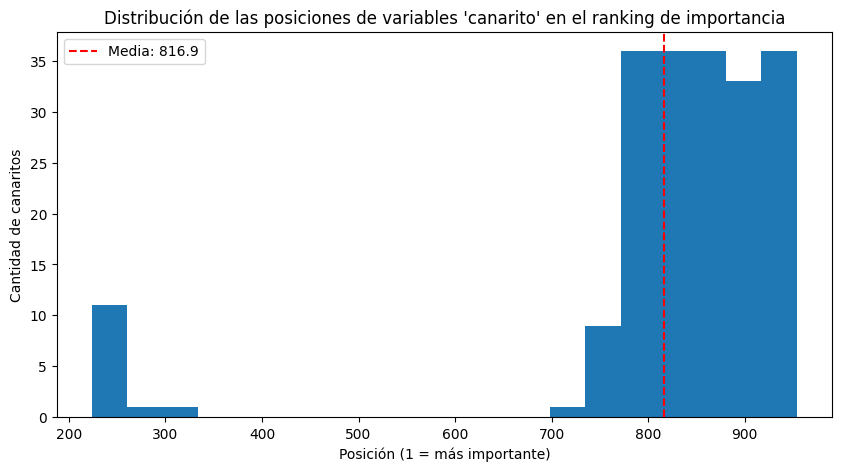

Posición media de las variables 'canarito': 816.9


In [ ]:

# # Gráfico
# plt.figure(figsize=(10, 5))
# plt.hist(canaritos["Rank"], bins=20)
# plt.axvline(pos_media_canaritos, color='red', linestyle='--', label=f"Media: {pos_media_canaritos:.1f}")
# plt.title("Distribución de las posiciones de variables 'canarito' en el ranking de importancia")
# plt.xlabel("Posición (1 = más importante)")
# plt.ylabel("Cantidad de canaritos")
# plt.legend()
# plt.show()

# print(f"Posición media de las variables 'canarito': {pos_media_canaritos:.1f}")

#Ganancia modelo clase 211 MARS sin nada
Ganancia modelo optimizaod acá, 331 mars

## Entrenar Modelos


In [ ]:
#Modelo entrenado sólo con 1 2 y 3

In [15]:

import json 
# ============================================================
# CARGAR MODELO GUARDADO
# ============================================================

print("Cargando modelo guardado...")
model_test = lgb.Booster(model_file='data/modelo_train_test.txt')
print("✅ Modelo cargado exitosamente")

# ============================================================
# PREDECIR EN KAGGLE
# ============================================================

print("\n" + "="*60)
print("PREDICCIONES PARA KAGGLE")
print("="*60)

# Cargar el número óptimo de envíos
print("Cargando número óptimo de envíos...")
with open('data/resultados_test.json', 'r') as f:
    resultados_test = json.load(f)

n_envios_optimo = resultados_test['n_envios_optimo']
print(f"Número óptimo de envíos: {n_envios_optimo:,}")

# Preparar datos de Kaggle
print("\nPreparando datos de Kaggle...")
X_kaggle = df_kaggle.drop("clase_ternaria", axis=1).to_numpy().astype('float32')
clientes_kaggle = df_kaggle["numero_de_cliente"].to_numpy()

print(f"Datos de Kaggle: {X_kaggle.shape}")

# Predicciones probabilísticas
print("Generando predicciones...")
y_pred_prob = model_test.predict(X_kaggle)

# Seleccionar top N clientes
print(f"Seleccionando top {n_envios_optimo:,} clientes...")
indices_top = np.argsort(-y_pred_prob)[:n_envios_optimo]

# Crear predicción binaria
y_pred_bin = np.zeros(len(y_pred_prob), dtype=int)
y_pred_bin[indices_top] = 1

# Crear submission
submission = pd.DataFrame({
    "numero_de_cliente": clientes_kaggle,
    "Predicted": y_pred_bin
})


Cargando modelo guardado...
✅ Modelo cargado exitosamente

PREDICCIONES PARA KAGGLE
Cargando número óptimo de envíos...
Número óptimo de envíos: 10,712

Preparando datos de Kaggle...
Datos de Kaggle: (164313, 802)
Generando predicciones...
Seleccionando top 10,712 clientes...


In [16]:

# Guardar
submission.to_csv("data/predicciones_kaggle.csv", index=False)

print(f"\n✅ Archivo guardado: 'data/predicciones_kaggle.csv'")
print(f"Total registros: {len(submission):,}")
print(f"Predicciones positivas (1): {y_pred_bin.sum():,}")
print(f"Predicciones negativas (0): {(y_pred_bin == 0).sum():,}")

print("\n📄 Primeras filas:")
print(submission.head())


✅ Archivo guardado: 'data/predicciones_kaggle.csv'
Total registros: 164,313
Predicciones positivas (1): 10,712
Predicciones negativas (0): 153,601

📄 Primeras filas:
   numero_de_cliente  Predicted
0          433987585          0
1          434200463          0
2          434285203          0
3          434436672          0
4          434468833          0


## Modelo entrenado con 01..04

Modelo multiples semillas 

In [ ]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import json
import gc
from datetime import datetime

# ============================================================
# PREPARAR DATOS: TRAIN + TEST COMBINADOS
# ============================================================

print("="*60)
print("PREPARANDO DATOS: TRAIN + TEST COMBINADOS")
print("="*60)

# 1. Crear pesos en df_train
print("Creando pesos en df_train...")
df_train['clase_peso'] = 1.0
df_train.loc[df_train['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_train.loc[df_train['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

# # 2. Crear pesos en df_test
print("Creando pesos en df_test...")
df_test['clase_peso'] = 1.0
df_test.loc[df_test['clase_ternaria'] == 'BAJA+2', 'clase_peso'] = 1.00002
df_test.loc[df_test['clase_ternaria'] == 'BAJA+1', 'clase_peso'] = 1.00001

# # 3. Concatenar df_train y df_test
print("Concatenando df_train y df_test...")
df_full = pd.concat([df_train, df_test], axis=0, ignore_index=True)

print(f"df_train: {df_train.shape}")
print(f"df_test: {df_test.shape}")
print(f"df_full: {df_full.shape}")

# 4. Convertir a numpy (optimizado) - SIN numero_de_cliente
print("\nConvirtiendo a numpy (float32)...")
X_full = df_full.drop(["clase_ternaria", "clase_peso", "numero_de_cliente"], axis=1).to_numpy().astype('float32')
y_full = df_full["clase_ternaria"].to_numpy()
pesos_full = df_full["clase_peso"].to_numpy().astype('float32')

# Binarizar
y_full_binaria = (y_full != "CONTINUA").astype('int8')

print(f"X_full: {X_full.shape}, dtype: {X_full.dtype}")
print(f"y_full_binaria: {y_full_binaria.shape}, dtype: {y_full_binaria.dtype}")
print(f"Clase positiva: {y_full_binaria.sum():,}")
print(f"Clase negativa: {(y_full_binaria == 0).sum():,}")

# Liberar memoria
print("\nLiberando df_train, df_test, df_full de memoria...")
del df_train, df_test, df_full, y_full
gc.collect()

print("✅ Datos preparados")

# ============================================================
# DEFINIR MÉTRICA PERSONALIZADA DE GANANCIA
# ============================================================

ganancia_acierto = 780000
costo_estimulo = 20000

def ganancia_lgb(y_pred, data):
    """Métrica personalizada de ganancia para LightGBM."""
    weight = data.get_weight()
    
    # Calcular ganancia para cada predicción
    ganancia = np.where(weight == 1.00002, ganancia_acierto, 0) - costo_estimulo
    
    # Ordenar por predicción descendente
    indices = np.argsort(-y_pred)
    ganancia_ordenada = ganancia[indices]
    
    # Calcular ganancia acumulada máxima
    ganancia_acum = np.cumsum(ganancia_ordenada)
    max_ganancia = np.max(ganancia_acum)
    
    return 'ganancia', max_ganancia, True

# ============================================================
# CARGAR HIPERPARÁMETROS
# ============================================================

print("\n" + "="*60)
print("CARGANDO HIPERPARÁMETROS")
print("="*60)

with open('data/mejores_hiperparametros2.json', 'r') as f:
    data = json.load(f)

config = data[0] if isinstance(data, list) else data

print(f"Trial {config['trial_number']}")
print(f"Ganancia esperada: ${config['value']:,.0f}")
print(f"Iteraciones: {config['best_iter']}")

# ============================================================
# ENTRENAR UN MODELO POR SEMILLA
# ============================================================

print("\n" + "="*60)
print(f"ENTRENANDO {len(SEMILLAS)} MODELOS (UNO POR SEMILLA)")
print("="*60)

modelos = []

for i, semilla in enumerate(SEMILLAS):
    print(f"\n--- Modelo {i+1}/{len(SEMILLAS)} - Semilla: {semilla} ---")
    
    # Configurar parámetros con la semilla correspondiente
    params = {
        'objective': 'binary',
        'metric': 'custom',
        'boosting_type': 'gbdt',
        'first_metric_only': True,
        'boost_from_average': True,
        'feature_pre_filter': False,
        'max_bin': 31,
        'num_leaves': config['params']['num_leaves'],
        'learning_rate': config['params']['learning_rate'],
        'min_data_in_leaf': config['params']['min_data_in_leaf'],
        'feature_fraction': config['params']['feature_fraction'],
        'bagging_fraction': config['params']['bagging_fraction'],
        'seed': semilla,  # ✅ Cambiar semilla
        'verbose': -1  # Silencioso para no saturar output
    }
    
    # Crear dataset
    full_data = lgb.Dataset(X_full,
                            label=y_full_binaria,
                            weight=pesos_full)
    
    # Entrenar modelo
    print(f"Entrenando con {config['best_iter']} iteraciones...")
    model = lgb.train(
        params,
        full_data,
        num_boost_round=config['best_iter'],
        feval=ganancia_lgb,
        callbacks=[lgb.log_evaluation(period=0)]  # Sin logs
    )
    
    # Guardar modelo
    model.save_model(f'data/predicciones/modelo_semilla_{semilla}.txt')
    print(f"✅ Modelo guardado: 'data/predicciones/modelo_semilla_{semilla}.txt'")
    
    # Agregar a la lista
    modelos.append(model)
    
    # Liberar memoria
    del full_data
    gc.collect()

print(f"\n✅ {len(modelos)} modelos entrenados exitosamente")

# Liberar X_full de memoria
del X_full, y_full_binaria, pesos_full
gc.collect()

# ============================================================
# CARGAR DF_KAGGLE Y PREDECIR CON CADA MODELO
# ============================================================

print("\n" + "="*60)
print("CARGANDO DF_KAGGLE Y PREDICIENDO")
print("="*60)

# Leer df_kaggle con tipos optimizados
print("Leyendo df_kaggle...")
columnas = pd.read_csv("data/df_kaggle.csv", nrows=0).columns.tolist()

# Crear diccionario de tipos: float32 para todas EXCEPTO numero_de_cliente
dtypes = {col: 'float32' for col in columnas if col not in ['numero_de_cliente', 'clase_ternaria']}

df_kaggle = pd.read_csv(
    "data/df_kaggle.csv",
    dtype=dtypes,
    low_memory=True
)

print(f"df_kaggle: {df_kaggle.shape}")
print(f"Tipo de numero_de_cliente: {df_kaggle['numero_de_cliente'].dtype}")

# Preparar datos
clientes_kaggle = df_kaggle["numero_de_cliente"].values
X_kaggle = df_kaggle.drop(["clase_ternaria", "numero_de_cliente"], axis=1).to_numpy().astype('float32')

print(f"X_kaggle: {X_kaggle.shape}, dtype={X_kaggle.dtype}")

del df_kaggle
gc.collect()

# ============================================================
# PREDECIR CON CADA MODELO Y PROMEDIAR
# ============================================================

print("\n" + "="*60)
print("GENERANDO PREDICCIONES CON CADA MODELO")
print("="*60)

# Inicializar array para acumular probabilidades
probabilidades_acumuladas = np.zeros(len(X_kaggle), dtype='float64')

for i, (model, semilla) in enumerate(zip(modelos, SEMILLAS)):
    print(f"\nModelo {i+1}/{len(modelos)} - Semilla {semilla}")
    print("Prediciendo...")
    
    y_pred_prob = model.predict(X_kaggle)
    
    print(f"  Prob min: {y_pred_prob.min():.6f}")
    print(f"  Prob max: {y_pred_prob.max():.6f}")
    print(f"  Prob media: {y_pred_prob.mean():.6f}")
    
    # Acumular probabilidades
    probabilidades_acumuladas += y_pred_prob
    
    # Liberar modelo de memoria
    del model
    gc.collect()

# Promediar probabilidades
print("\n" + "="*60)
print("PROMEDIANDO PROBABILIDADES")
print("="*60)

y_pred_prob_promedio = probabilidades_acumuladas / len(SEMILLAS)

print(f"Probabilidades promediadas:")
print(f"  Prob min: {y_pred_prob_promedio.min():.6f}")
print(f"  Prob max: {y_pred_prob_promedio.max():.6f}")
print(f"  Prob media: {y_pred_prob_promedio.mean():.6f}")

# Guardar probabilidades promediadas (opcional)
np.save('data/predicciones/probabilidades_promedio.npy', y_pred_prob_promedio)
print("\n✅ Probabilidades guardadas en 'data/predicciones/probabilidades_promedio.npy'")

# ============================================================
# BINARIZAR CON NÚMERO ÓPTIMO DE ENVÍOS
# ============================================================

print("\n" + "="*60)
print("BINARIZANDO PREDICCIONES")
print("="*60)

n_envios_optimo = 12300
print(f"Número de envíos: {n_envios_optimo:,}")

# Seleccionar top N clientes
indices_top = np.argsort(-y_pred_prob_promedio)[:n_envios_optimo]

# Crear predicción binaria
y_pred_bin = np.zeros(len(y_pred_prob_promedio), dtype='int8')
y_pred_bin[indices_top] = 1

# ============================================================
# CREAR SUBMISSION
# ============================================================

print("\n" + "="*60)
print("CREANDO SUBMISSION")
print("="*60)

submission = pd.DataFrame({
    "numero_de_cliente": clientes_kaggle,
    "Predicted": y_pred_bin
})

# Verificar tipos
print(f"Tipos en submission:")
print(f"  numero_de_cliente: {submission['numero_de_cliente'].dtype}")
print(f"  Predicted: {submission['Predicted'].dtype}")
# Obtener fecha y hora actual en formato YYYYMMDD_HHMM
fecha = datetime.now().strftime("%Y%m%d_%H%M")

# Crear el nombre del archivo con fecha incluida
filename = f"data/predicciones_kaggle_ensemble_{len(SEMILLAS)}semillas_{n_envios_optimo}_{fecha}.csv"
submission.to_csv(filename, index=False)

print(f"\n✅ Archivo guardado: '{filename}'")
print(f"\n📊 RESUMEN:")
print(f"  Modelos entrenados: {len(SEMILLAS)}")
print(f"  Total registros: {len(submission):,}")
print(f"  Predicciones positivas (1): {y_pred_bin.sum():,}")
print(f"  Predicciones negativas (0): {(y_pred_bin == 0).sum():,}")
print(f"  % positivos: {y_pred_bin.sum() / len(submission) * 100:.2f}%")

print("\n📄 Primeras 10 filas:")
print(submission.head(10))

print("\nVerificación de IDs:")
print(f"  Primer ID: {submission['numero_de_cliente'].iloc[0]}")
print(f"  Último ID: {submission['numero_de_cliente'].iloc[-1]}")

print("\n🎉 Ensemble de modelos completado - Predicciones listas para Kaggle!")

PREPARANDO DATOS: TRAIN + TEST COMBINADOS
Creando pesos en df_train...
Creando pesos en df_test...
Concatenando df_train y df_test...
df_train: (5284, 804)
df_test: (163418, 804)
df_full: (168702, 804)

Convirtiendo a numpy (float32)...
X_full: (168702, 801), dtype: float32
y_full_binaria: (168702,), dtype: int8
Clase positiva: 7,369
Clase negativa: 161,333

Liberando df_train, df_test, df_full de memoria...
✅ Datos preparados

CARGANDO HIPERPARÁMETROS
Trial 218
Ganancia esperada: $1,235,980,000
Iteraciones: 98

ENTRENANDO 5 MODELOS (UNO POR SEMILLA)

--- Modelo 1/5 - Semilla: 550007 ---
Entrenando con 98 iteraciones...
✅ Modelo guardado: 'data/predicciones/modelo_semilla_550007.txt'

--- Modelo 2/5 - Semilla: 550019 ---
Entrenando con 98 iteraciones...
✅ Modelo guardado: 'data/predicciones/modelo_semilla_550019.txt'

--- Modelo 3/5 - Semilla: 550031 ---
Entrenando con 98 iteraciones...
✅ Modelo guardado: 'data/predicciones/modelo_semilla_550031.txt'

--- Modelo 4/5 - Semilla: 550033 -

## -4k era entrenado con 01..03 y predecir 06 con los mejores hiperparametros de mi primer corrida (30) con metric ganancia
## -3k simil anterior pero modelo reentrenado con 01..04 con metric AUC 
## -3 K simil anterior pero modelo reentrenado con 01..04 con metric custom
## -2 umbral fijo de 12k 
## 0 de 01 02 y 03 sólo los baja+1/2. 

## voy a probar con slopes. no me sirvió. solo con dl tampoco (aunque no optimicé hip para esto)

## 2 con ensamble de semillas
1 si dejo los continua de marzo
4 con hiperparametros optimizados 500. hip2
5 con num fijo de 12300. esto es con fe todo sin slopes
3 Optimizacion con Claude y regularizacion. NO FUNCIONO